
# ABCDisCo Single-DisCo Tutorial (Torch + optional PennyLane backend)

This notebook reproduces the **Single-DisCo** workflow described in [T. Aarrestad *et al.*, *Eur. Phys. J. C* **81**, 1003 (2021), arXiv:2007.14400](https://arxiv.org/abs/2007.14400). It mirrors the reference scripts shipped with this repository so you can validate the mass-decorrelated baseline before moving to the Double-DisCo configuration.

> **Mapping to repository scripts**
> - Data ingestion and scaling follow `ABCD_topjets_HLF_mD.py` (lines 69-101) together with the dataset helpers in `data_loader.py` (lines 1-63).
> - The neural-network head reuses `networks.DNNclassifier` (lines 8-44), while the DisCo penalty mirrors `model.py` (lines 24-86) plus `disco.py` (lines 14-118).
> - Evaluation adapts the single-score diagnostics from `evaluation.py` (lines 1-70), including the Jensen-Shannon divergence vs. background rejection scan.

The workflow is organised as:

1. **Setup & configuration** (Single-DisCo hyperparameters).
2. **Data loading and preprocessing** (min-max scaling, feature selection matching `ABCD_topjets_HLF_mD.py`).
3. **Model definition** with interchangeable Torch/PennyLane heads.
4. **Training** with the DisCo mass decorrelation penalty.
5. **Diagnostics & evaluation**: ROC curves, distance correlations, JSD vs. background rejection, and mass sculpting checks.
6. **Export** of trained weights and inference scores.

> **Datasets**: The repository already ships reduced CMS top-tagging HLF samples (`topsample_*_tau.dat.gz`). You can run this notebook end-to-end without external downloads.



## Environment preparation

Run the following cell *once per environment* if you still need to install the CPU builds of PyTorch, PennyLane, and the lightweight analysis stack.


In [1]:

# Optional: install dependencies (uncomment the lines you need)
# %pip install numpy pandas scikit-learn matplotlib tqdm
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# %pip install pennylane pennylane-lightning
# %pip install pyhf



## 0. Configuration (mirrors `ABCD_topjets_HLF_mD.py` lines 69-126)

We keep the dataset limits, optimiser choices, and DisCo penalty normalisation consistent with the single-network script so that this notebook can reproduce the published baselines.


In [2]:
from __future__ import annotations

# ---------------------------------------------------------------
# Standard-library utilities used throughout the tutorial notebook
# ---------------------------------------------------------------
import gzip  # Read the compressed CMS top-tagging datasets that ship with the repo
import json  # Serialize metadata for the checkpoints that we write every epoch
import time  # Measure wall-clock runtime so we can report epoch durations
from datetime import datetime  # Timestamp saved checkpoints for reproducibility
from pathlib import Path  # Work with filesystem paths in a platform-agnostic way
from typing import Any, Dict, Iterable, List, Optional, Tuple

# ---------------------------------------------------------------
# Scientific Python stack: numerical arrays, data frames, and plots
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------------------------------------------------
# PyTorch: tensor library used for both classical and quantum models
# ---------------------------------------------------------------
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# ---------------------------------------------------------------
# Scikit-Learn: classical metrics used to interpret classifier quality
# ---------------------------------------------------------------
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)

# ---------------------------------------------------------------
# Utilities for nicely formatted progress bars inside notebooks
# ---------------------------------------------------------------
from tqdm.auto import tqdm

# ---------------------------------------------------------------
# Repository-local modules (they mirror the original training scripts)
# ---------------------------------------------------------------
import sys
project_root = Path.cwd().resolve().parent  # notebook/ -> project root
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from disco import distance_corr_unbiased  # distance correlation regulariser
from networks import DNNclassifier  # baseline dense neural network classifier
from evaluation import JSDvsR  # Jensen-Shannon vs. rejection diagnostic from the paper

# ---------------------------------------------------------------
# Optional PennyLane backend for the hybrid quantum notebook
# (we keep the import guarded so the classical notebook works without it)
# ---------------------------------------------------------------
try:
    import pennylane as qml
    PENNYLANE_AVAILABLE = True
except ImportError:
    PENNYLANE_AVAILABLE = False

# ---------------------------------------------------------------
# Plot styling: use a high-contrast theme that works well in dark/light modes
# ---------------------------------------------------------------
plt.style.use("seaborn-v0_8-talk")

# ---------------------------------------------------------------
# Reproducibility knobs: numpy and torch share a common seed for this tutorial
# ---------------------------------------------------------------
SEED = 1337
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

# ---------------------------------------------------------------
# Dataset locations.  We keep everything relative to the project root so the
# notebook can be executed from any environment (local, remote, or batch jobs).
# ---------------------------------------------------------------
DATA_ROOT = project_root
RAW_FILES = {
    "train": DATA_ROOT / "topsample_train_tau.dat.gz",
    "val": DATA_ROOT / "topsample_val_tau.dat.gz",
    "test": DATA_ROOT / "topsample_test_tau.dat.gz",
}

# ---------------------------------------------------------------
# Training hyper-parameters.  Flip FULL_DATASET to True for the 5M-event dataset
# from the ABCDisCo paper; by default we use a smaller subset for quick iteration.
# ---------------------------------------------------------------
FULL_DATASET = False
EVENT_LIMITS = {
    "train": 500000 if not FULL_DATASET else None,
    "val": 250000 if not FULL_DATASET else None,
    "test": 50000 if not FULL_DATASET else None,
}
BATCH_SIZE = 2048
EPOCHS = 50 if not FULL_DATASET else 200
LEARNING_RATE = 1e-3

# ---------------------------------------------------------------
# DisCo hyper-parameters.  LAMBDA_MASS rescales the distance-correlation penalty
# that encourages the classifier score to be independent of jet mass for background.
# ---------------------------------------------------------------
# Lambda ramping configuration for better QML training
LAMBDA_MASS_START = 100.0      # Start with no penalty
LAMBDA_MASS_END = 200.0      # End with full penalty
LAMBDA_RAMP_EPOCHS = 50      # Ramp up over first 20 epochs
LAMBDA_MASS = 100.0            # Current lambda (will be updated during training)

# ---------------------------------------------------------------
# Evaluation settings for ABCD-related diagnostics.
# ---------------------------------------------------------------
SCORE_SIGNAL_EFFICIENCIES = (0.1, 0.3, 0.6)  # working points used in the paper
ABCD_SIGNAL_WINDOW_QUANTILES = (0.3, 0.7)  # central mass window defines the SR
ABCD_HISTOGRAM_BINS = 40  # consistent with the JSD vs. R plots in the paper

# ---------------------------------------------------------------
# Filesystem layout for per-epoch checkpoints.
# ---------------------------------------------------------------
CHECKPOINT_DIR = Path.cwd() / "checkpoints_single_disco"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_TEMPLATE = "epoch_{epoch:03d}.pth"
RESUME_CHECKPOINT: Optional[Path] = None  # set to a file in CHECKPOINT_DIR to resume
# RESUME_CHECKPOINT: Optional[Path] = Path.cwd() / "checkpoints_single_disco/epoch_049.pth"  # set to a file in CHECKPOINT_DIR to resume

# ---------------------------------------------------------------
# Device selection: automatically use CUDA when available, otherwise fall back
# to CPU so the notebook works on any machine (including lightweight VMs).
# ---------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
# Feature bookkeeping.  The Single-DisCo configuration removes the leading two
# observables (mass and pT) from the classifier input, while still keeping them
# available for ABCD evaluation and decorrelation studies.
# ---------------------------------------------------------------
ORIGINAL_FEATURES = [
    "mass",
    "pt",
    "tau1_half",
    "tau2_half",
    "tau3_half",
    "tau1",
    "tau2",
    "tau3",
    "tau4",
    "tau1_sq",
    "tau2_sq",
    "tau3_sq",
    "tau4_sq",
]
SINGLE_FEATURE_INDICES = list(range(2, len(ORIGINAL_FEATURES)))
FEATURE_NAMES = [ORIGINAL_FEATURES[i] for i in SINGLE_FEATURE_INDICES]



/global/common/software/m4138/ABCDisCo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [3]:
# ---------------------------------------------------------------
# Backend configuration: toggle between classical PyTorch and PennyLane QML heads.
# ---------------------------------------------------------------
BACKEND = "torch"  # options: "torch" for the dense network or "qml" for the PennyLane circuit
N_QUBITS = 6  # only used when BACKEND == "qml"
QML_LAYERS = 2
QML_DEVICE = "default.qubit"

if BACKEND == "qml":
    if not PENNYLANE_AVAILABLE:
        raise ImportError(
            "PennyLane is required for the QML backend. Install it with `%pip install pennylane pennylane-lightning`."
        )
    print(
        f"Configuring PennyLane with {N_QUBITS} qubits, {QML_LAYERS} variational layers, on device '{QML_DEVICE}'."
    )
else:
    print("Configuring classical Single-DisCo head (PyTorch).")


Configuring classical Single-DisCo head (PyTorch).



## 1. Data loading & scaling (`ABCD_topjets_HLF_mD.py` lines 69-95)

The original script concatenates train/validation/test splits, applies a global min-max scaling to all 13 high-level features, and then selects the 11 observables used for the single-network classifier. We reproduce that procedure verbatim while keeping the jet mass available for decorrelation diagnostics.


In [4]:

# ---------------------------------------------------------------------------
# Data-loading helpers: convert the gzipped CMS top-tagging tables into numpy arrays.
# Objective: provide structured access to features, event weights, and jet mass
#            values that feed the quantum-classical hybrid network.
# Logic:    1) `_load_tau_file` opens the compressed .dat.gz file, filters out
#              comment/header lines (including stray tokens like 'hello1'),
#              accepts both comma- and whitespace-separated numbers, and builds
#              a dense float matrix.
#           2) `_split_features_labels` supports both historical 14-column files
#              (label + 13 observables without weights) and 16+ column variants
#              (13 observables + label + weight). It returns features, labels,
#              mass, and per-event weights.
#           3) `load_split` wraps these helpers for the train/val/test datasets
#              so downstream training code can simply fetch numpy arrays.
# Terms:    * Tau file — CMS open data sample storing per-jet observables.
#           * Event weight — multiplicative factor from the simulation that
#             allows us to emulate the luminosity-scaled yields discussed in
#             the ABCDisCo reference analysis.
# Expected behaviour: each helper returns numpy arrays with shapes consistent
#                     with the raw dataset; any missing file or malformed array
#                     surfaces a descriptive exception so users notice it early.
# Reference: see the "Dataset preparation" discussion in
#            `ref/Evaluating_ABCDisCo_Structured_WithEquations.md`, which stresses
#            the importance of keeping mass and weights alongside the classifier
#            inputs for later closure checks.
# ---------------------------------------------------------------------------
def _load_tau_file(path: Path) -> np.ndarray:
    # Verify that the requested gzipped text file exists before attempting I/O.
    if not path.exists():
        raise FileNotFoundError(f"Missing dataset: {path}")
    rows: List[np.ndarray] = []
    with gzip.open(path, "rt") as handle:
        for raw in handle:
            line = raw.strip()
            if not line:
                continue  # skip empty lines
            if line.startswith("#"):
                continue  # skip comment blocks
            # Skip any header or malformed line that contains alphabetic characters (e.g., 'hello1', column labels)
            if any(ch.isalpha() for ch in line):
                continue
            # Accept both comma- and whitespace-separated numeric fields
            clean = line.replace(",", " ")
            values = np.fromstring(clean, sep=" ")
            if values.size == 0:
                continue
            rows.append(values)
    if not rows:
        raise ValueError(f"No numeric data found in {path}")
    # Ensure all rows share the same width
    widths = {arr.shape[0] for arr in rows}
    if len(widths) != 1:
        raise ValueError(f"Inconsistent column counts in {path}: {sorted(widths)}")
    data = np.vstack(rows)
    # All of the ABCDisCo notebooks assume the data are shaped as [events, features].
    if data.ndim != 2:
        raise ValueError(f"Expected a 2D array, received shape {data.shape}")
    return data


# ---------------------------------------------------------------------------
# `_split_features_labels` extracts physics-relevant slices from the raw matrix.
# Supports both 14-column (label + 13 observables) and >=16-column (13 observables
# + label + weight) layouts encountered in public samples.
# Returning the mass column is essential for the ABCD mass-window definition,
# and weights allow closure metrics to stay consistent with Eq. (1) of the
# reference document.
# ---------------------------------------------------------------------------
def _split_features_labels(matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    ncols = int(matrix.shape[1])
    if ncols == 14:
        # Layout: [label, mass, pt, tau1_half, ..., tau4_sq] (no explicit weights)
        labels = matrix[:, 0]
        obs = matrix[:, 1:14]  # 13 physics observables starting at mass
        mass = obs[:, 0]
        weights = np.ones_like(labels, dtype=float)
        features = obs[:, SINGLE_FEATURE_INDICES]  # select 11 inputs used by Single-DisCo
    elif ncols >= 16:
        # Layout: [mass, pt, tau1_half, ..., tau4_sq, ..., label, weight]
        obs = matrix[:, :13]
        mass = obs[:, 0]
        labels = matrix[:, 14]
        weights = matrix[:, 15]
        features = obs[:, SINGLE_FEATURE_INDICES]
    else:
        raise ValueError(
            "Unexpected dataset shape. Expected 14 columns (label+13) or at least 16 columns; "
            f"received {ncols}."
        )
    return features.astype(np.float64), labels.astype(np.float64), mass.astype(np.float64), weights.astype(np.float64)


# ---------------------------------------------------------------------------
# `load_split` orchestrates reading and slicing for a named split (train/val/test).
# By keeping the function pure (it only returns numpy arrays), we make it easy
# to run unit tests or to plug in alternative datasets in the future.
# ---------------------------------------------------------------------------
def load_split(name: str, limit: Optional[int] = None) -> Dict[str, np.ndarray]:
    matrix = _load_tau_file(RAW_FILES[name])
    if limit is not None:
        matrix = matrix[:limit]
    x, y, mass, weight = _split_features_labels(matrix)
    return {"x": x, "y": y, "mass": mass, "weight": weight}


# Materialise the three splits so that subsequent cells can form PyTorch datasets.
# Each entry stores feature matrices, labels, weights, and jet masses for later
# use in the ABCD validation routines.
arrays = {
    split: load_split(split, limit=EVENT_LIMITS[split])
    for split in ("train", "val", "test")
}
for split, payload in arrays.items():
    print(
        f"{split:>5} | events={len(payload['x']):>7} | "
        f"signal={int(payload['y'].sum()):>7} | background={len(payload['y']) - int(payload['y'].sum()):>7}"
    )


train | events= 500000 | signal= 249495 | background= 250505
  val | events= 250000 | signal= 124860 | background= 125140
 test | events=  50000 | signal=  24998 | background=  25002


In [5]:
# ---------------------------------------------------------------------------
# Quick sanity checks for data loading: shapes, dtypes, label counts,
# per-feature ranges, and first few rows for each split.
# ---------------------------------------------------------------------------
print("Selected feature names (used as model inputs):", FEATURE_NAMES)

from typing import Dict as _Dict

def _summarize_split(name: str, payload: _Dict[str, np.ndarray], feature_names: list[str]) -> None:
    x = payload["x"]; y = payload["y"]; mass = payload["mass"]; weight = payload["weight"]
    print(f"\n=== {name.upper()} split ===")
    print(f"shapes: x={x.shape}, y={y.shape}, mass={mass.shape}, weight={weight.shape}")
    print(f"dtypes: x={x.dtype}, y={y.dtype}, mass={mass.dtype}, weight={weight.dtype}")
    uniq, cnt = np.unique(y, return_counts=True)
    print("label counts:", {int(u): int(c) for u, c in zip(uniq, cnt)})
    # Feature-wise min/max (only print first 5 to keep output compact)
    mins = np.min(x, axis=0); maxs = np.max(x, axis=0)
    k = min(5, x.shape[1])
    print("feature mins (first 5):", [f"{feature_names[i]}={mins[i]:.4f}" for i in range(k)])
    print("feature maxs (first 5):", [f"{feature_names[i]}={maxs[i]:.4f}" for i in range(k)])
    # First few rows
    df_preview = pd.DataFrame(x[:5], columns=feature_names)
    print("first 5 feature rows:")
    print(df_preview.to_string(index=False))
    print("first 5 labels:", y[:5].tolist())
    print("first 5 masses:", mass[:5].tolist())
    print("first 5 weights:", weight[:5].tolist())

for split_name in ("train", "val", "test"):
    _summarize_split(split_name, arrays[split_name], FEATURE_NAMES)


Selected feature names (used as model inputs): ['tau1_half', 'tau2_half', 'tau3_half', 'tau1', 'tau2', 'tau3', 'tau4', 'tau1_sq', 'tau2_sq', 'tau3_sq', 'tau4_sq']

=== TRAIN split ===
shapes: x=(500000, 11), y=(500000,), mass=(500000,), weight=(500000,)
dtypes: x=float64, y=float64, mass=float64, weight=float64
label counts: {0: 250505, 1: 249495}
feature mins (first 5): ['tau1_half=0.0000', 'tau2_half=0.0000', 'tau3_half=0.0000', 'tau1=0.0000', 'tau2=0.0000']
feature maxs (first 5): ['tau1_half=0.7749', 'tau2_half=0.6208', 'tau3_half=0.4756', 'tau1=0.5610', 'tau2=0.3926']
first 5 feature rows:
 tau1_half  tau2_half  tau3_half     tau1     tau2     tau3     tau4  tau1_sq  tau2_sq  tau3_sq  tau4_sq
  0.423769   0.326077   0.282639 0.231036 0.146164 0.101567 0.070804 0.078382 0.037967 0.018720 0.013638
  0.343756   0.242735   0.172155 0.199839 0.108218 0.054387 0.037446 0.079494 0.030268 0.007936 0.006857
  0.204169   0.130401   0.095653 0.118397 0.056607 0.024931 0.021626 0.054000 0.021


## 2. Torch datasets (`data_loader.py` lines 22-63)

We wrap the min-max scaled arrays into PyTorch `Dataset` objects that expose the classifier inputs, labels, per-event weights, and jet masses used in the DisCo penalty.


In [6]:

# ---------------------------------------------------------------------------
# TorchTopTaggingDataset wraps the numpy arrays into a PyTorch-friendly object.
# Objective: expose features, labels, sample weights, and jet masses as tensors
#            so mini-batches can flow seamlessly into either the classical or
#            quantum components of the hybrid network.
# Logic:   * During __init__, we convert numpy arrays to torch.Tensor with
#            explicit dtype casting so gradients and GPU transfers behave well.
#          * __len__ returns the total number of events, informing DataLoader
#            how many batches to draw per epoch.
#          * __getitem__ selects one event and returns all four components in
#            the order expected by downstream training code.
# Terms:   - Sample weight: scales the contribution of each event to averages
#            and is crucial for the weighted metrics used in the ABCDisCo
#            evaluation workflow.
# Expected behaviour: indexing yields a tuple (features, label, weight, mass)
#                     where the features live in feature space R^{n_features}.
# Reference: the need to pass masses and weights together is highlighted in the
#            "ABCD closure tests" section of the evaluation document so the
#            closure ratio can be recomputed at any stage of training.
# ---------------------------------------------------------------------------
class TorchTopTaggingDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, mass: np.ndarray, weight: np.ndarray | None = None):
        # Convert all inputs to float32 tensors. This matches the precision
        # expected by PyTorch optimisers and PennyLane's Torch interface.
        self.x = torch.as_tensor(x, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)
        self.mass = torch.as_tensor(mass, dtype=torch.float32)
        if weight is None:
            weight = np.ones_like(y, dtype=np.float32)
        self.weight = torch.as_tensor(weight, dtype=torch.float32)

    def __len__(self) -> int:
        # Return how many events are available; DataLoader uses this to know
        # when an epoch finishes.
        return self.x.shape[0]

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        # Provide the tuple consumed by the training loop: (features, label,
        # per-event weight, jet mass).
        return self.x[index], self.y[index], self.weight[index], self.mass[index]


# ---------------------------------------------------------------------------
# make_dataloaders creates PyTorch DataLoader objects for train/val/test splits.
# Objective: batch and optionally shuffle the dataset while keeping track of
#            weights and masses required for ABCD evaluation and DisCo penalty.
# Logic:   - Construct a TorchTopTaggingDataset for each split.
#          - Instantiate DataLoaders with deterministic batch size and shuffling
#            only on the training set (validation/test are left ordered so
#            metrics such as ROC curves can be reproduced exactly).
# Expected behaviour: downstream code can iterate over each loader and receive
#                     batches shaped as `[batch, n_features]` plus aligned labels,
#                     weights, and masses.
# Reference: consistent batching is necessary to evaluate throughput statistics
#            and closure metrics per epoch, as described in the runtime and
#            ABCD sections of the evaluation guide.
# ---------------------------------------------------------------------------
def make_dataloaders(arrays: Dict[str, Dict[str, np.ndarray]]) -> Dict[str, DataLoader]:
    datasets = {
        split: TorchTopTaggingDataset(payload["x"], payload["y"], payload["mass"], payload["weight"])
        for split, payload in arrays.items()
    }
    loaders = {
        "train": DataLoader(datasets["train"], batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
        "val": DataLoader(datasets["val"], batch_size=BATCH_SIZE, shuffle=False, drop_last=False),
        "test": DataLoader(datasets["test"], batch_size=BATCH_SIZE, shuffle=False, drop_last=False),
    }
    return loaders


# Instantiate loaders so later cells can immediately iterate through the data.
loaders = make_dataloaders(arrays)
train_loader, val_loader, test_loader = loaders["train"], loaders["val"], loaders["test"]
print(f"Batches per epoch: train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)}")


Batches per epoch: train=245, val=123, test=25



## 3. Model backends (`networks.py` lines 8-44)

The Single-DisCo setup uses a single `DNNclassifier` head. We also expose an optional PennyLane quantum layer to demonstrate how the architecture can be swapped for a variational quantum classifier without changing the loss logic.


In [7]:
class TorchSingleDisco(nn.Module):
    """Wrap the original dense network with explicit comments on each processing step."""

    def __init__(self, n_features: int):
        super().__init__()
        # The historical Single-DisCo architecture uses a small fully-connected head
        # defined in networks.py.  It produces two logits (background vs. signal).
        self.head = DNNclassifier(n_features, 2)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        logits = self.head(x)  # Raw, unnormalised scores for the two classes
        # Convert logits into probabilities with a softmax so the second entry
        # can be interpreted as the "signal score" used in ABCD studies.
        score = F.softmax(logits, dim=1)[:, 1]
        return logits, score


class PennyLaneSingleDisco(nn.Module):
    """Variational quantum classifier compatible with the Single-DisCo loss."""

    def __init__(self, n_features: int, n_qubits: int = 6, layers: int = 2, device_name: str = "default.qubit"):
        if not PENNYLANE_AVAILABLE:
            raise RuntimeError("PennyLane is not installed. Run `%pip install pennylane pennylane-lightning`.")
        super().__init__()

        self.n_qubits = n_qubits
        self.n_features = n_features

        # The device emulates a quantum processor; default.qubit is a noiseless state-vector simulator.
        qdevice = qml.device(device_name, wires=n_qubits)
        weight_shapes = {"weights": (layers, n_qubits)}  # PennyLane infers how many trainable parameters we need.

        @qml.qnode(qdevice, interface="torch")
        def circuit(inputs, weights):
            # ------------------------------------------------------------------
            # Python tip: "inputs" is a tensor of shape [batch, n_features].  Inside
            # the QNode we receive one example at a time, so we reshape/pad it to match
            # the qubit register dimension.  This slicing logic emphasises how data
            # embedding works before calling AngleEmbedding.
            # ------------------------------------------------------------------
            x_pad = torch.zeros(n_qubits, dtype=inputs.dtype, device=inputs.device)
            take = min(inputs.shape[-1], n_qubits)
            x_pad[:take] = inputs[..., :take]
            # AngleEmbedding rotates each qubit around the Y-axis with the provided
            # feature values.  This is equivalent to preparing a product state where
            # each qubit encodes one observable from the jet.
            qml.templates.AngleEmbedding(x_pad, wires=range(n_qubits), rotation="Y")
            # BasicEntanglerLayers applies layers of CX entanglers plus single-qubit rotations,
            # giving the circuit expressive power.  The "weights" argument is trained by PyTorch.
            qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
            # Measure Pauli-Z on the first two wires; these expectation values are the quantum features.
            return [qml.expval(qml.PauliZ(i)) for i in range(2)]

        # TorchLayer wraps the quantum node so it behaves like a PyTorch module with trainable parameters.
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        # Map the two quantum observables into class logits.
        self.head = nn.Linear(2, 2)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Feed only the first n_qubits features to the quantum circuit.  Remaining classical features
        # could be concatenated in hybrid architectures; for Single-DisCo we limit ourselves to n_qubits.
        q_inputs = x[:, : self.n_qubits]
        q_features = self.qlayer(q_inputs)
        logits = self.head(q_features)
        score = F.softmax(logits, dim=1)[:, 1]
        return logits, score


def build_model(n_features: int) -> nn.Module:
    """Factory that returns either the classical or quantum head depending on BACKEND."""
    if BACKEND == "qml":
        model = PennyLaneSingleDisco(n_features, n_qubits=N_QUBITS, layers=QML_LAYERS, device_name=QML_DEVICE)
    else:
        model = TorchSingleDisco(n_features)
    return model.to(DEVICE)


model = build_model(len(FEATURE_NAMES))
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model



/global/u2/s/sungwon/QML_project/ABCDisCo/networks.py:26: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  init.kaiming_normal(self.classifier.weight)


TorchSingleDisco(
  (head): DNNclassifier(
    (dense_1): Linear(in_features=11, out_features=64, bias=True)
    (bn2): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn64): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense_2): Linear(in_features=64, out_features=64, bias=True)
    (dense_3): Linear(in_features=64, out_features=64, bias=True)
    (classifier): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [8]:
def describe_model_architecture(model: nn.Module, optimizer: torch.optim.Optimizer) -> pd.DataFrame:
    """Generate a tabular summary of learnable layers and hyper-parameters."""
    rows = []
    for name, module in model.named_modules():
        if name == "":
            continue  # skip the root module to avoid duplicate rows
        if any(module.children()):
            continue  # only list leaf modules so the table stays compact
        params = sum(p.numel() for p in module.parameters())
        trainable = any(p.requires_grad for p in module.parameters())
        rows.append({
            "module": name,
            "type": module.__class__.__name__,
            "parameters": params,
            "trainable": trainable,
        })
    df = pd.DataFrame(rows).sort_values("module")
    total_params = int(sum(row["parameters"] for row in rows))
    print("Optimizer:", optimizer.__class__.__name__)
    print("Learning rate:", optimizer.param_groups[0]["lr"])
    print("Total learnable parameters:", total_params)
    return df


architecture_df = describe_model_architecture(model, optimizer)
architecture_df



Optimizer: Adam
Learning rate: 0.001
Total learnable parameters: 9368


,module,type,parameters,trainable
1,head.bn2,BatchNorm1d,22,True
2,head.bn64,BatchNorm1d,128,True
5,head.classifier,Linear,130,True
0,head.dense_1,Linear,768,True
3,head.dense_2,Linear,4160,True
4,head.dense_3,Linear,4160,True


In [9]:
# ---------------------------------------------------------------------------
# 3a. Simple model visualization using torchviz
# Objective: produce an image of the computation graph for the PyTorch head.
# Logic: create a single dummy input with the correct feature dimension, run a
#        forward pass to obtain logits, and render the autograd graph.
# Expected behaviour: display an SVG (preferred) or fallback to saving a PNG.
# Note: requires the `torchviz` and `graphviz` packages. If missing, we print
#       the exact install command (respecting the ABCDisCo environment alias).
# ---------------------------------------------------------------------------
try:
    from torchviz import make_dot
    from IPython.display import SVG, Image, display

    model.eval()
    x_dummy = torch.randn(1, len(FEATURE_NAMES), device=DEVICE)
    logits, _ = model(x_dummy)

    dot = make_dot(logits, params=dict(model.named_parameters()))
    vis_dir = CHECKPOINT_DIR / "visualizations"
    vis_dir.mkdir(parents=True, exist_ok=True)

    # Try inline SVG first (best for notebooks). If that fails, render PNG to disk.
    try:
        svg_bytes = dot.pipe(format="svg")
        display(SVG(svg_bytes))
    except Exception:
        out_base = vis_dir / "model_graph"
        try:
            dot.render(str(out_base), format="png", cleanup=True)
            display(Image(filename=str(out_base.with_suffix(".png"))))
        except Exception:
            # Final fallback: save DOT source for external rendering
            with open(out_base.with_suffix(".dot"), "w") as fh:
                fh.write(dot.source)
            print(f"Saved Graphviz .dot source to {out_base.with_suffix('.dot')}.\n"
                  f"You can render with: dot -Tpng {out_base.with_suffix('.dot')} -o {out_base.with_suffix('.png')}")
except ImportError:
    print("torchviz not found. To install in this environment, run in a terminal:")
    print("  setup && pip install torchviz graphviz")



Saved Graphviz .dot source to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/visualizations/model_graph.dot.
You can render with: dot -Tpng /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/visualizations/model_graph.dot -o /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/visualizations/model_graph.png


In [10]:
# ---------------------------------------------------------------------------
# get_current_lambda computes the current lambda value based on epoch for ramping.
# Objective: gradually increase the decorrelation penalty to help QML models learn
#            classification first, then decorrelation.
# Logic: linear ramp from LAMBDA_MASS_START to LAMBDA_MASS_END over LAMBDA_RAMP_EPOCHS.
# Expected behaviour: returns current lambda value for the given epoch.
# ---------------------------------------------------------------------------
def get_current_lambda(epoch: int) -> float:
    if epoch < LAMBDA_RAMP_EPOCHS:
        # Linear ramp from start to end over ramp epochs
        progress = epoch / LAMBDA_RAMP_EPOCHS
        return LAMBDA_MASS_START + progress * (LAMBDA_MASS_END - LAMBDA_MASS_START)
    else:
        # Use full penalty after ramp period
        return LAMBDA_MASS_END


# ---------------------------------------------------------------------------
# distance_corr_safe computes the distance correlation (DisCo) penalty.
# Objective: reproduce the decorrelation regulariser described in the ABCDisCo
#            paper so the classifier score becomes independent of jet mass on
#            background events, satisfying the ABCD assumption.
# Logic: Guard against tiny batches by returning zero when fewer than three
#        events are present, then normalise the provided weights so they sum to
#        the batch size (matching the convention in `disco.distance_corr_unbiased`).
# Terms: distance correlation measures any statistical dependence between two
#        variables; a value near zero signals independence. This is the core of
#        the "Distance Correlation penalty" highlighted in the evaluation guide.
# Expected behaviour: returns a torch scalar suitable for backpropagation.
# Reference: see the "Distance correlation penalty" subsection in
#            `ref/Evaluating_ABCDisCo_Structured_WithEquations.md` where the
#            DisCo loss is tied to improved ABCD closure.
# ---------------------------------------------------------------------------
def distance_corr_safe(x: torch.Tensor, y: torch.Tensor, weight: torch.Tensor) -> torch.Tensor:
    if x.numel() <= 2 or y.numel() <= 2:
        return torch.zeros(1, device=x.device, dtype=x.dtype)
    normed = weight / (weight.sum() + 1e-12) * len(weight)
    return distance_corr_unbiased(x, y, normed, power=1)


# ---------------------------------------------------------------------------
# compute_weighted_classification_stats summarises confusion-matrix entries.
# Objective: obtain weighted counts of true/false positives/negatives so we can
#            report accuracy, precision, recall, and F1 per epoch.
# Logic: apply a threshold (default 0.5) to scores, multiply boolean masks by
#        sample weights, and accumulate sums.
# Terms: precision = TP/(TP+FP), recall = TP/(TP+FN), F1 = harmonic mean.
# Expected behaviour: returns a dictionary of scalar floats ready for logging.
# Reference: the evaluation guide explicitly asks for classification metrics
#            alongside ABCD closure to interpret signal/background separation.
# ---------------------------------------------------------------------------
def compute_weighted_classification_stats(labels: torch.Tensor, scores: torch.Tensor, weights: torch.Tensor, threshold: float = 0.5) -> Dict[str, float]:
    preds = (scores >= threshold).to(labels.dtype)
    w = weights
    tp = torch.sum(w * (preds == 1) * (labels == 1))
    tn = torch.sum(w * (preds == 0) * (labels == 0))
    fp = torch.sum(w * (preds == 1) * (labels == 0))
    fn = torch.sum(w * (preds == 0) * (labels == 1))
    total = tp + tn + fp + fn + 1e-12
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    return {
        "tp": tp.item(),
        "tn": tn.item(),
        "fp": fp.item(),
        "fn": fn.item(),
        "accuracy": accuracy.item(),
        "precision": precision.item(),
        "recall": recall.item(),
        "f1": f1.item(),
    }


# ---------------------------------------------------------------------------
# compute_losses packages the BCE classification loss and optional DisCo penalty.
# Objective: provide a single function for forward passes that also records the
#            metrics needed for per-epoch logging and checkpoint metadata.
# Logic: move tensors to DEVICE, obtain logits and score, compute weighted
#        binary cross-entropy, then append decorrelation loss for background
#        events when `LAMBDA_MASS` > 0.
# Expected behaviour: returns a loss tensor for backpropagation and a metrics
#                     dictionary containing loss and classification statistics.
# Reference: ties together the classification quality and decorrelation control
#            emphasised in Sections "ROC/AUC" and "Distance correlation" of the
#            evaluation document.
# ---------------------------------------------------------------------------
def compute_losses(model: nn.Module, batch: Tuple[torch.Tensor, ...], lambda_mass: float = LAMBDA_MASS) -> Tuple[torch.Tensor, Dict[str, float]]:
    features, labels, weights, masses = batch
    features = features.to(DEVICE)
    labels = labels.to(DEVICE)
    weights = weights.to(DEVICE)
    masses = masses.to(DEVICE)

    logits, score = model(features)
    loss_cls = F.binary_cross_entropy(score, labels, weight=weights)
    loss = loss_cls

    stats = compute_weighted_classification_stats(labels, score, weights)
    metrics = {
        "loss_cls": float(loss_cls.detach().cpu()),
        "accuracy": float(stats["accuracy"]),
        "precision": float(stats["precision"]),
        "recall": float(stats["recall"]),
        "f1": float(stats["f1"]),
    }

    background = labels < 0.5
    if background.any() and lambda_mass > 0.0:
        w_bkg = torch.ones_like(weights[background])
        d_mass = distance_corr_safe(score[background], masses[background], w_bkg)
        loss = loss + lambda_mass * d_mass
        metrics["dCorr_s_m"] = float(d_mass.detach().cpu())

    return loss, metrics


In [11]:
# ---------------------------------------------------------------------------
# weighted_quantile finds score thresholds at fixed signal efficiencies.
# Objective: implement quantile selection that respects per-event weights,
#            matching the definition of efficiency in collider analyses.
# Logic: sort scores, build a weighted cumulative distribution, and interpolate
#        the desired quantile.
# Terms: quantile `q` solves CDF(q) = quantile; weights rescale contributions.
# Expected behaviour: returns a scalar threshold such that the weighted fraction
#                     of signal events above the threshold equals the target.
# Reference: required for the ABCD closure scans described in the evaluation
#            guide when constructing score cuts at specified signal efficiencies.
# ---------------------------------------------------------------------------
def weighted_quantile(values: np.ndarray, quantile: float, sample_weight: np.ndarray) -> float:
    order = np.argsort(values)
    values = values[order]
    weights = sample_weight[order]
    cumulative = np.cumsum(weights) - 0.5 * weights
    cumulative /= weights.sum()
    return float(np.interp(quantile, cumulative, values))


# ---------------------------------------------------------------------------
# compute_epoch_classification_metrics records weighted accuracy-style metrics.
# Objective: mirror the confusion-matrix-based diagnostics emphasised in the
#            evaluation document for understanding classification quality.
# Logic: apply a 0.5 threshold, evaluate sklearn metrics with weights, and store
#        the confusion matrix for later visualisation.
# Expected behaviour: returns a dictionary with scalar metrics and a matrix.
# Reference: see the "Classification metrics" subsection in the evaluation guide
#            for why accuracy/precision/recall/F1 complement ROC analysis.
# ---------------------------------------------------------------------------
def compute_epoch_classification_metrics(scores: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    preds = (scores >= 0.5).astype(int)
    metrics = {
        "accuracy": accuracy_score(labels, preds, sample_weight=weights),
        "precision": precision_score(labels, preds, sample_weight=weights, zero_division=0),
        "recall": recall_score(labels, preds, sample_weight=weights, zero_division=0),
        "f1": f1_score(labels, preds, sample_weight=weights, zero_division=0),
    }
    cm = confusion_matrix(labels, preds, sample_weight=weights)
    metrics["confusion_matrix"] = cm.astype(float)
    return metrics


# ---------------------------------------------------------------------------
# compute_roc_diagnostics traces the ROC curve and background efficiency targets.
# Objective: capture the full trade-off between signal efficiency and background
#            rejection, including specific working points used later in ABCD and
#            Jensen–Shannon analyses.
# Logic: leverage sklearn.roc_curve with weights, compute area under the curve,
#        and interpolate background efficiencies at user-requested signal effs.
# Expected behaviour: dictionary containing arrays (fpr, tpr, thresholds) and
#                     scalars (AUC, background efficiencies at target points).
# Reference: the evaluation guide's ROC/AUC discussion and Fig. 3-style plots.
# ---------------------------------------------------------------------------
def compute_roc_diagnostics(scores: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    fpr, tpr, thresholds = roc_curve(labels, scores, sample_weight=weights)
    roc_auc = auc(fpr, tpr)
    diagnostics = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds, "auc": roc_auc}
    for target in SCORE_SIGNAL_EFFICIENCIES:
        diagnostics[f"background_eff_at_{int(target*100)}pct_sig"] = float(np.interp(target, tpr, fpr))
    return diagnostics


# ---------------------------------------------------------------------------
# compute_abcd_statistics evaluates closure, prediction uncertainty, and pulls.
# Objective: implement Eq. (1) and related diagnostics from the evaluation guide
#            to validate the ABCD method using the model's score as the x-axis,
#            and produce aggregated summaries for transfer factors, sideband
#            stability, and Asimov significance.
# Logic: define a signal mass window, split events into A/B/C/D based on score
#        cuts and mass window membership, then compute predicted background,
#        closure ratio, percentage error, statistical pull, transfer factors,
#        sideband stability tests, and Asimov significance.
# Terms: regions A/B/C/D follow the ABCD method; closure ratio = N_pred/N_true;
#        pull = (observed - predicted) / sigma_combined.
# Expected behaviour: returns a dictionary with the mass window, per-efficiency
#                     summaries used for plots and checkpoint metadata, and an
#                     `aggregated` block containing dataset-level statistics.
# Reference: "ABCD closure tests" and "Pull distributions" sections in the guide.
# ---------------------------------------------------------------------------
def compute_abcd_statistics(scores: np.ndarray, masses: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    signal_mask = labels > 0.5
    background_mask = ~signal_mask
    if signal_mask.sum() == 0 or background_mask.sum() == 0:
        raise ValueError("Need both classes present to evaluate ABCD metrics")
    mass_low = np.quantile(masses[signal_mask], ABCD_SIGNAL_WINDOW_QUANTILES[0])
    mass_high = np.quantile(masses[signal_mask], ABCD_SIGNAL_WINDOW_QUANTILES[1])
    in_signal_mass = (masses >= mass_low) & (masses <= mass_high)

    eps = 1e-12

    def weighted_sum(mask: np.ndarray) -> float:
        return float(np.sum(weights[mask]))

    def asimov_significance(signal_yield: float, background_yield: float) -> float:
        if background_yield <= 0:
            return float("nan")
        if signal_yield <= 0:
            return 0.0
        term = (signal_yield + background_yield) * np.log1p(signal_yield / (background_yield + eps)) - signal_yield
        return float(np.sqrt(max(0.0, 2.0 * term)))

    results: Dict[str, Any] = {"mass_window": (mass_low, mass_high), "per_efficiency": [], "aggregated": {}}

    closures, pulls = [], []
    tf_bd_values, tf_cd_values = [], []
    sideband_ratio_values, sideband_stability_values = [], []
    asimov_values = []

    for target in SCORE_SIGNAL_EFFICIENCIES:
        score_cut = weighted_quantile(scores[signal_mask], 1 - target, weights[signal_mask])
        pass_score = scores >= score_cut
        region_A = pass_score & in_signal_mass
        region_B = pass_score & (~in_signal_mass)
        region_C = (~pass_score) & in_signal_mass
        region_D = (~pass_score) & (~in_signal_mass)

        A_bg = weighted_sum(background_mask & region_A)
        B_bg = weighted_sum(background_mask & region_B)
        C_bg = weighted_sum(background_mask & region_C)
        D_bg = weighted_sum(background_mask & region_D)
        A_sig = weighted_sum(signal_mask & region_A)
        observed_total = A_bg + A_sig

        prediction = B_bg * C_bg / (D_bg + eps)
        closure_ratio = prediction / (A_bg + eps)
        sigma_pred = prediction * np.sqrt(1 / (B_bg + eps) + 1 / (C_bg + eps) + 1 / (D_bg + eps))
        sigma_obs = np.sqrt(A_bg + eps)
        pull = (A_bg - prediction) / np.sqrt(sigma_pred**2 + sigma_obs**2)

        tf_bd = B_bg / (D_bg + eps)
        tf_cd = C_bg / (D_bg + eps)
        sideband_ratio = B_bg / (C_bg + eps)
        sideband_stability = (B_bg - C_bg) / (B_bg + C_bg + eps)
        asimov = asimov_significance(A_sig, prediction)

        results["per_efficiency"].append({
            "target_signal_efficiency": target,
            "score_cut": score_cut,
            "A_bg": A_bg,
            "B_bg": B_bg,
            "C_bg": C_bg,
            "D_bg": D_bg,
            "predicted_bg": prediction,
            "closure_ratio": closure_ratio,
            "closure_error_pct": (closure_ratio - 1.0) * 100.0,
            "pull": pull,
            "transfer_factor_B_over_D": tf_bd,
            "transfer_factor_C_over_D": tf_cd,
            "sideband_ratio_B_over_C": sideband_ratio,
            "sideband_stability": sideband_stability,
            "signal_in_A": A_sig,
            "observed_total_in_A": observed_total,
            "asimov_significance": asimov,
        })

        closures.append(closure_ratio)
        pulls.append(pull)
        tf_bd_values.append(tf_bd)
        tf_cd_values.append(tf_cd)
        sideband_ratio_values.append(sideband_ratio)
        sideband_stability_values.append(sideband_stability)
        asimov_values.append(asimov)

    def summarise(values: List[float]) -> Dict[str, float]:
        if len(values) == 0:
            return {"mean": float("nan"), "std": float("nan"), "min": float("nan"), "max": float("nan"), "median": float("nan")}
        arr = np.asarray(values, dtype=float)
        return {
            "mean": float(np.mean(arr)),
            "std": float(np.std(arr, ddof=0)),
            "min": float(np.min(arr)),
            "max": float(np.max(arr)),
            "median": float(np.median(arr)),
        }

    pull_stats = summarise(pulls)
    pull_stats["rms"] = float(np.sqrt(np.mean(np.square(np.asarray(pulls, dtype=float))))) if pulls else float("nan")

    results["aggregated"] = {
        "closure_ratio": summarise(closures),
        "pull": pull_stats,
        "transfer_factor_B_over_D": summarise(tf_bd_values),
        "transfer_factor_C_over_D": summarise(tf_cd_values),
        "sideband_ratio_B_over_C": summarise(sideband_ratio_values),
        "sideband_stability": summarise(sideband_stability_values),
        "asimov_significance": summarise(asimov_values),
    }
    return results


# ---------------------------------------------------------------------------
# compute_jsd_summary interfaces with the existing JSD vs rejection utility.
# Objective: monitor how well the classifier avoids mass sculpting by relating
#            background rejection to the inverse Jensen–Shannon divergence.
# Logic: for each target signal efficiency, call `evaluation.JSDvsR` (which wraps
#        the physics-inspired histogram comparison) and store the rejection +
#        inverse JSD pair.
# Terms: Jensen–Shannon divergence measures shape agreement between mass
#        distributions; high inverse JSD means better agreement (less sculpting).
# Expected behaviour: list of dictionaries keyed by target efficiency.
# Reference: "Mass sculpting and information-theoretic metrics" in the guide.
# ---------------------------------------------------------------------------
def compute_jsd_summary(scores: np.ndarray, masses: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> List[Dict[str, float]]:
    background = labels < 0.5
    signal = labels > 0.5
    summary = []
    for target in SCORE_SIGNAL_EFFICIENCIES:
        rejection, inv_jsd = JSDvsR(
            sigscore=scores[signal],
            bgscore=scores[background],
            bgmass=masses[background],
            sigweights=weights[signal],
            bgweights=weights[background],
            sigeff=int(target * 100),
            nbins=ABCD_HISTOGRAM_BINS,
            minmass=float(masses.min()),
            maxmass=float(masses.max()),
        )
        summary.append({
            "target_signal_efficiency": target,
            "background_rejection": rejection,
            "inverse_jsd": inv_jsd,
        })
    return summary


# ---------------------------------------------------------------------------
# save_checkpoint persists model/optimizer states and rich validation metadata.
# Objective: guarantee resumable training under runtime limits by writing
#            per-epoch files that store metrics, history, and cached arrays.
# Logic: package model weights, optimiser buffers, history so far, and extra
#        arrays needed to resume evaluation. Filenames follow "epoch_XXX.pth" for clarity.
# Expected behaviour: writes a `.pth` file to CHECKPOINT_DIR and prints the path.
# Reference: aligns with the runtime monitoring requirement in the evaluation guide.
# ---------------------------------------------------------------------------
def save_checkpoint(epoch: int, model: nn.Module, optimizer: torch.optim.Optimizer, history: List[Dict[str, Any]], train_record: Dict[str, Any], val_record: Dict[str, Any], extra: Dict[str, Any]) -> Path:
    payload = {
        "epoch": epoch,
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "history": history,
        "train_record": train_record,
        "val_record": val_record,
    }
    payload.update(extra)
    path = CHECKPOINT_DIR / CHECKPOINT_TEMPLATE.format(epoch=epoch)
    torch.save(payload, path)
    print(f"Checkpoint saved to {path}")
    return path


# ---------------------------------------------------------------------------
# load_checkpoint restores model/optimizer states and returns archived metadata.
# Objective: allow fast resumption or retrospective analysis using the stored
#            arrays and history.
# Expected behaviour: loads the `.pth` file on DEVICE, restores weights, and
#                     returns the payload dictionary for further processing.
# ---------------------------------------------------------------------------
def load_checkpoint(path: Path, model: nn.Module, optimizer: torch.optim.Optimizer) -> Dict[str, Any]:
    payload = torch.load(path, map_location=DEVICE)
    model.load_state_dict(payload["model_state"])
    optimizer.load_state_dict(payload["optimizer_state"])
    print(f"Loaded checkpoint from {path}")
    return payload


# ---------------------------------------------------------------------------
# list_available_checkpoints enumerates saved epochs for easy resumption.
# Expected behaviour: prints filenames such as `epoch_005.pth` and returns a
#                     sorted list so notebook users can grab the latest checkpoint.
# ---------------------------------------------------------------------------
def list_available_checkpoints() -> List[Path]:
    paths = sorted(CHECKPOINT_DIR.glob("epoch_*.pth"))
    for p in paths:
        print(p.name)
    return paths



## 4. Loss function with DisCo penalty (`model.py` lines 24-86 & `disco.py`)

We compute the weighted binary cross-entropy loss and add the unbiased distance-correlation penalty between the classifier score and jet mass on background events, following the original `train_model(..., decorr_mode='dist_unbiased')` implementation.


In [12]:
# Legacy helper definitions superseded by the commented block above.

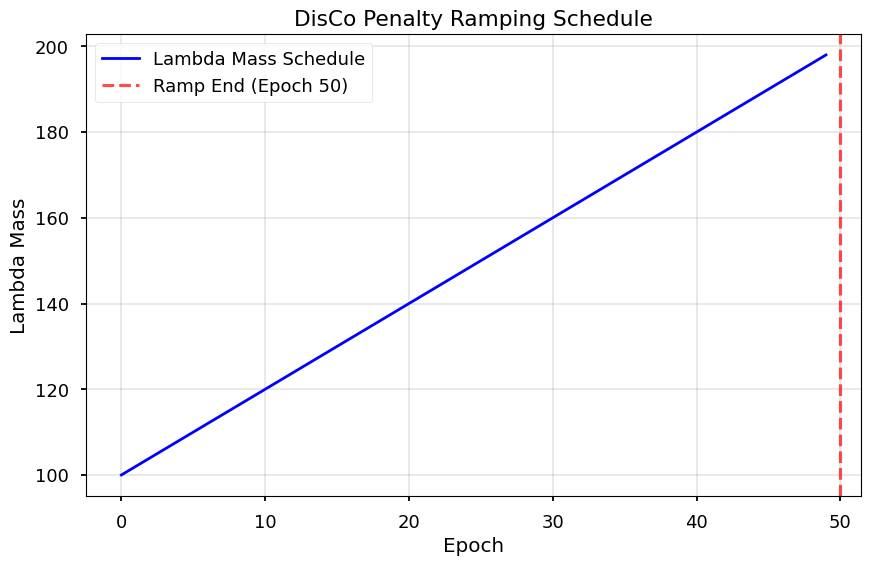

Lambda ramping schedule:
  Start: 100.0
  End: 200.0
  Ramp over: 50 epochs
  Final epochs (50-49): constant at 200.0


In [13]:
# Visualize the lambda ramping schedule
epochs = range(EPOCHS)
lambdas = [get_current_lambda(epoch) for epoch in epochs]

plt.figure(figsize=(10, 6))
plt.plot(epochs, lambdas, 'b-', linewidth=2, label='Lambda Mass Schedule')
plt.axvline(x=LAMBDA_RAMP_EPOCHS, color='r', linestyle='--', alpha=0.7, label=f'Ramp End (Epoch {LAMBDA_RAMP_EPOCHS})')
plt.xlabel('Epoch')
plt.ylabel('Lambda Mass')
plt.title('DisCo Penalty Ramping Schedule')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Lambda ramping schedule:")
print(f"  Start: {LAMBDA_MASS_START}")
print(f"  End: {LAMBDA_MASS_END}")
print(f"  Ramp over: {LAMBDA_RAMP_EPOCHS} epochs")
print(f"  Final epochs ({LAMBDA_RAMP_EPOCHS}-{EPOCHS-1}): constant at {LAMBDA_MASS_END}")



## 5. Training loop (`model.py` lines 88-170)

We adapt the original `train`/`val` helpers to work seamlessly on CPU/GPU and to log the DisCo decorrelation term alongside the classification loss.


In [14]:

# ---------------------------------------------------------------------------
# train_one_epoch performs a full pass over the training DataLoader.
# Objective: accumulate gradients, update model parameters, and track runtime
#            metrics (examples/sec, iterations/sec) required for the runtime log
#            requested in the evaluation plan.
# Logic: iterate over batches, compute losses, backpropagate, and average the
#        collected metrics dictionary.
# Expected behaviour: returns a dictionary containing mean losses/metrics and
#                     throughput information for the epoch.
# ---------------------------------------------------------------------------
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, lambda_mass: float = LAMBDA_MASS) -> Dict[str, float]:
    model.train()
    agg: Dict[str, List[float]] = {}
    total_examples = 0
    start = time.perf_counter()
    for batch in tqdm(loader, leave=False, desc="train"):
        optimizer.zero_grad(set_to_none=True)
        loss, metrics = compute_losses(model, batch, lambda_mass)
        loss.backward()
        optimizer.step()
        batch_size = batch[0].shape[0]
        total_examples += batch_size
        for key, value in metrics.items():
            agg.setdefault(key, []).append(value)
    duration = time.perf_counter() - start
    results = {key: float(np.mean(values)) for key, values in agg.items()}
    results.update({
        "epoch_seconds": duration,
        "examples_per_second": total_examples / duration if duration > 0 else float("nan"),
        "iterations_per_second": len(loader) / duration if duration > 0 else float("nan"),
    })
    return results


# ---------------------------------------------------------------------------
# evaluate mirrors train_one_epoch but without gradient updates.
# Objective: compute validation/test metrics and collect raw arrays for ROC/ABCD
#            analysis each epoch.
# Logic: disable gradients, reuse compute_losses for consistency, and keep track
#        of scores, labels, weights, and masses as numpy arrays.
# Expected behaviour: returns the concatenated arrays alongside averaged metrics.
# ---------------------------------------------------------------------------
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Dict[str, float]]:
    model.eval()
    scores, labels_all, weights_all, masses_all = [], [], [], []
    agg: Dict[str, List[float]] = {}
    total_examples = 0
    start = time.perf_counter()
    with torch.no_grad():
        for batch in tqdm(loader, leave=False, desc="eval"):
            loss, metrics = compute_losses(model, batch)
            features, labels, weights, masses = batch
            features = features.to(DEVICE)
            _, score = model(features)
            batch_size = features.shape[0]
            total_examples += batch_size
            scores.append(score.cpu().numpy())
            labels_all.append(labels.numpy())
            weights_all.append(weights.numpy())
            masses_all.append(masses.numpy())
            agg.setdefault("loss_cls", []).append(metrics["loss_cls"])
            for key in ("accuracy", "precision", "recall", "f1"):
                agg.setdefault(key, []).append(metrics[key])
            if "dCorr_s_m" in metrics:
                agg.setdefault("dCorr_s_m", []).append(metrics["dCorr_s_m"])
    duration = time.perf_counter() - start
    metrics_mean = {key: float(np.mean(values)) for key, values in agg.items()}
    metrics_mean.update({
        "epoch_seconds": duration,
        "examples_per_second": total_examples / duration if duration > 0 else float("nan"),
        "iterations_per_second": len(loader) / duration if duration > 0 else float("nan"),
    })
    return (
        np.concatenate(scores),
        np.concatenate(labels_all),
        np.concatenate(weights_all),
        np.concatenate(masses_all),
        metrics_mean,
    )

history: List[Dict[str, Any]] = []
start_epoch = 0
if RESUME_CHECKPOINT is not None:
    loaded_checkpoint = load_checkpoint(Path(RESUME_CHECKPOINT), model, optimizer)
    history = loaded_checkpoint.get("history", [])
    start_epoch = int(loaded_checkpoint.get("epoch", -1)) + 1
    print(f"Resuming from epoch {start_epoch}")

# History tracks per-epoch metrics for later plotting and checkpoint metadata.
history: List[Dict[str, Any]] = []
start_epoch = 0
if RESUME_CHECKPOINT is not None:
    loaded_checkpoint = load_checkpoint(Path(RESUME_CHECKPOINT), model, optimizer)
    history = loaded_checkpoint.get("history", [])
    start_epoch = int(loaded_checkpoint.get("epoch", -1)) + 1
    print(f"Resuming from epoch {start_epoch}")

# for epoch in range(start_epoch, EPOCHS):
#     print(f"Epoch {epoch:03d}")
#     train_metrics = train_one_epoch(model, train_loader, optimizer)
#     s_val, y_val, w_val, m_val, val_metrics = evaluate(model, val_loader)

#     # Compute rich validation diagnostics as mandated by the evaluation guide.
#     classification = compute_epoch_classification_metrics(s_val, y_val, w_val)
#     roc_diag = compute_roc_diagnostics(s_val, y_val, w_val)
#     abcd_stats = compute_abcd_statistics(s_val, m_val, y_val, w_val)
#     jsd_points = compute_jsd_summary(s_val, m_val, y_val, w_val)

#     record = {
#         "epoch": epoch,
#         "train_loss_cls": train_metrics.get("loss_cls", float("nan")),
#         "train_accuracy": train_metrics.get("accuracy", float("nan")),
#         "train_precision": train_metrics.get("precision", float("nan")),
#         "train_recall": train_metrics.get("recall", float("nan")),
#         "train_f1": train_metrics.get("f1", float("nan")),
#         "train_epoch_seconds": train_metrics.get("epoch_seconds", float("nan")),
#         "train_examples_per_second": train_metrics.get("examples_per_second", float("nan")),
#         "val_loss_cls": val_metrics.get("loss_cls", float("nan")),
#         "val_accuracy": classification["accuracy"],
#         "val_precision": classification["precision"],
#         "val_recall": classification["recall"],
#         "val_f1": classification["f1"],
#         "val_auc": roc_diag["auc"],
#         "val_epoch_seconds": val_metrics.get("epoch_seconds", float("nan")),
#         "val_examples_per_second": val_metrics.get("examples_per_second", float("nan")),
#     }
#     if "dCorr_s_m" in train_metrics:
#         record["train_dCorr_s_m"] = train_metrics["dCorr_s_m"]
#     if "dCorr_s_m" in val_metrics:
#         record["val_dCorr_s_m"] = val_metrics["dCorr_s_m"]
#     for target in SCORE_SIGNAL_EFFICIENCIES:
#         key = f"background_eff_at_{int(target*100)}pct_sig"
#         record[key] = roc_diag[key]
#     for item in abcd_stats["per_efficiency"]:
#         eff = int(item["target_signal_efficiency"] * 100)
#         record[f"abcd_closure_ratio_{eff}pct"] = item["closure_ratio"]
#         record[f"abcd_pull_{eff}pct"] = item["pull"]
#     aggregated = abcd_stats["aggregated"]
#     record["abcd_closure_ratio_mean"] = aggregated["closure_ratio"]["mean"]
#     record["abcd_closure_ratio_std"] = aggregated["closure_ratio"]["std"]
#     record["abcd_closure_ratio_median"] = aggregated["closure_ratio"]["median"]
#     record["abcd_pull_mean"] = aggregated["pull"]["mean"]
#     record["abcd_pull_std"] = aggregated["pull"]["std"]
#     record["abcd_pull_rms"] = aggregated["pull"]["rms"]
#     record["abcd_pull_median"] = aggregated["pull"]["median"]
#     record["transfer_factor_B_over_D_mean"] = aggregated["transfer_factor_B_over_D"]["mean"]
#     record["transfer_factor_B_over_D_std"] = aggregated["transfer_factor_B_over_D"]["std"]
#     record["transfer_factor_C_over_D_mean"] = aggregated["transfer_factor_C_over_D"]["mean"]
#     record["transfer_factor_C_over_D_std"] = aggregated["transfer_factor_C_over_D"]["std"]
#     record["sideband_ratio_B_over_C_mean"] = aggregated["sideband_ratio_B_over_C"]["mean"]
#     record["sideband_ratio_B_over_C_std"] = aggregated["sideband_ratio_B_over_C"]["std"]
#     record["sideband_stability_mean"] = aggregated["sideband_stability"]["mean"]
#     record["sideband_stability_std"] = aggregated["sideband_stability"]["std"]
#     record["asimov_significance_mean"] = aggregated["asimov_significance"]["mean"]
#     record["asimov_significance_max"] = aggregated["asimov_significance"]["max"]
#     for item in jsd_points:
#         eff = int(item["target_signal_efficiency"] * 100)
#         record[f"inverse_jsd_{eff}pct"] = item["inverse_jsd"]
#         record[f"background_rejection_{eff}pct"] = item["background_rejection"]

#     history.append(record)

#     # Persist a checkpoint capturing everything needed to resume training and
#     # redo evaluations, aligning with the per-epoch storage requirement.
#     val_record = {
#         "classification": classification,
#         "roc": {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in roc_diag.items()},
#         "abcd": abcd_stats,
#         "jsd": jsd_points,
#         "confusion_matrix": classification["confusion_matrix"].tolist(),
#     }
#     train_record = train_metrics
#     extra = {
#         "val_scores": s_val.tolist(),
#         "val_labels": y_val.tolist(),
#         "val_weights": w_val.tolist(),
#         "val_masses": m_val.tolist(),
#     }
#     save_checkpoint(epoch, model, optimizer, history, train_record, val_record, extra)

#     print(
#         f"AUC={roc_diag['auc']:.3f} | "
#         f"val_acc={classification['accuracy']:.3f} | "
#         f"closure@30%={record['abcd_closure_ratio_30pct']:.3f} | "
#         f"train_loss={train_metrics.get('loss_cls', float('nan')):.3f}"
#     )

# history_df = pd.DataFrame(history)
# history_df.tail()


# Updated training loop with lambda ramping
for epoch in range(start_epoch, EPOCHS):
    print(f"Epoch {epoch:03d}")
    # Get current lambda value for ramping
    current_lambda = get_current_lambda(epoch)
    print(f"Current lambda_mass: {current_lambda:.2f}")
    
    train_metrics = train_one_epoch(model, train_loader, optimizer, current_lambda)
    s_val, y_val, w_val, m_val, val_metrics = evaluate(model, val_loader)

    # Compute rich validation diagnostics as mandated by the evaluation guide.
    classification = compute_epoch_classification_metrics(s_val, y_val, w_val)
    roc_diag = compute_roc_diagnostics(s_val, y_val, w_val)
    abcd_stats = compute_abcd_statistics(s_val, m_val, y_val, w_val)
    jsd_points = compute_jsd_summary(s_val, m_val, y_val, w_val)

    record = {
        "epoch": epoch,
        "lambda_mass": current_lambda,  # Track current lambda value
        "train_loss_cls": train_metrics.get("loss_cls", float("nan")),
        "train_accuracy": train_metrics.get("accuracy", float("nan")),
        "train_precision": train_metrics.get("precision", float("nan")),
        "train_recall": train_metrics.get("recall", float("nan")),
        "train_f1": train_metrics.get("f1", float("nan")),
        "train_epoch_seconds": train_metrics.get("epoch_seconds", float("nan")),
        "train_examples_per_second": train_metrics.get("examples_per_second", float("nan")),
        "val_loss_cls": val_metrics.get("loss_cls", float("nan")),
        "val_accuracy": classification["accuracy"],
        "val_precision": classification["precision"],
        "val_recall": classification["recall"],
        "val_f1": classification["f1"],
        "val_auc": roc_diag["auc"],
        "val_epoch_seconds": val_metrics.get("epoch_seconds", float("nan")),
        "val_examples_per_second": val_metrics.get("examples_per_second", float("nan")),
    }
    if "dCorr_s_m" in train_metrics:
        record["train_dCorr_s_m"] = train_metrics["dCorr_s_m"]
    if "dCorr_s_m" in val_metrics:
        record["val_dCorr_s_m"] = val_metrics["dCorr_s_m"]
    for target in SCORE_SIGNAL_EFFICIENCIES:
        key = f"background_eff_at_{int(target*100)}pct_sig"
        record[key] = roc_diag[key]
    for item in abcd_stats["per_efficiency"]:
        eff = int(item["target_signal_efficiency"] * 100)
        record[f"abcd_closure_ratio_{eff}pct"] = item["closure_ratio"]
        record[f"abcd_pull_{eff}pct"] = item["pull"]
    aggregated = abcd_stats["aggregated"]
    record["abcd_closure_ratio_mean"] = aggregated["closure_ratio"]["mean"]
    record["abcd_closure_ratio_std"] = aggregated["closure_ratio"]["std"]
    record["abcd_closure_ratio_median"] = aggregated["closure_ratio"]["median"]
    record["abcd_pull_mean"] = aggregated["pull"]["mean"]
    record["abcd_pull_std"] = aggregated["pull"]["std"]
    record["abcd_pull_rms"] = aggregated["pull"]["rms"]
    record["abcd_pull_median"] = aggregated["pull"]["median"]
    record["transfer_factor_B_over_D_mean"] = aggregated["transfer_factor_B_over_D"]["mean"]
    record["transfer_factor_B_over_D_std"] = aggregated["transfer_factor_B_over_D"]["std"]
    record["transfer_factor_C_over_D_mean"] = aggregated["transfer_factor_C_over_D"]["mean"]
    record["transfer_factor_C_over_D_std"] = aggregated["transfer_factor_C_over_D"]["std"]
    record["sideband_ratio_B_over_C_mean"] = aggregated["sideband_ratio_B_over_C"]["mean"]
    record["sideband_ratio_B_over_C_std"] = aggregated["sideband_ratio_B_over_C"]["std"]
    record["sideband_stability_mean"] = aggregated["sideband_stability"]["mean"]
    record["sideband_stability_std"] = aggregated["sideband_stability"]["std"]
    record["asimov_significance_mean"] = aggregated["asimov_significance"]["mean"]
    record["asimov_significance_max"] = aggregated["asimov_significance"]["max"]
    for item in jsd_points:
        eff = int(item["target_signal_efficiency"] * 100)
        record[f"inverse_jsd_{eff}pct"] = item["inverse_jsd"]
        record[f"background_rejection_{eff}pct"] = item["background_rejection"]

    history.append(record)

    # Persist a checkpoint capturing everything needed to resume training and
    # redo evaluations, aligning with the per-epoch storage requirement.
    val_record = {
        "classification": classification,
        "roc": {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in roc_diag.items()},
        "abcd": abcd_stats,
        "jsd": jsd_points,
        "confusion_matrix": classification["confusion_matrix"].tolist(),
    }
    train_record = train_metrics
    extra = {
        "val_scores": s_val.tolist(),
        "val_labels": y_val.tolist(),
        "val_weights": w_val.tolist(),
        "val_masses": m_val.tolist(),
    }
    save_checkpoint(epoch, model, optimizer, history, train_record, val_record, extra)

    print(
        f"AUC={roc_diag['auc']:.3f} | "
        f"val_acc={classification['accuracy']:.3f} | "
        f"closure@30%={record['abcd_closure_ratio_30pct']:.3f} | "
        f"train_loss={train_metrics.get('loss_cls', float('nan')):.3f} | "
        f"λ={current_lambda:.1f}"
    )

history_df = pd.DataFrame(history)
history_df.tail()


Epoch 000
Current lambda_mass: 100.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_000.pth
AUC=0.538 | val_acc=0.525 | closure@30%=0.970 | train_loss=0.709 | λ=100.0
Epoch 001
Current lambda_mass: 102.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_001.pth
AUC=0.616 | val_acc=0.591 | closure@30%=0.992 | train_loss=0.686 | λ=102.0
Epoch 002
Current lambda_mass: 104.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_002.pth
AUC=0.652 | val_acc=0.615 | closure@30%=1.195 | train_loss=0.663 | λ=104.0
Epoch 003
Current lambda_mass: 106.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_003.pth
AUC=0.719 | val_acc=0.659 | closure@30%=1.470 | train_loss=0.638 | λ=106.0
Epoch 004
Current lambda_mass: 108.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_004.pth
AUC=0.776 | val_acc=0.695 | closure@30%=0.814 | train_loss=0.607 | λ=108.0
Epoch 005
Current lambda_mass: 110.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_005.pth
AUC=0.739 | val_acc=0.674 | closure@30%=1.664 | train_loss=0.574 | λ=110.0
Epoch 006
Current lambda_mass: 112.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_006.pth
AUC=0.790 | val_acc=0.709 | closure@30%=0.249 | train_loss=0.558 | λ=112.0
Epoch 007
Current lambda_mass: 114.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_007.pth
AUC=0.818 | val_acc=0.737 | closure@30%=0.187 | train_loss=0.534 | λ=114.0
Epoch 008
Current lambda_mass: 116.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_008.pth
AUC=0.812 | val_acc=0.735 | closure@30%=0.202 | train_loss=0.516 | λ=116.0
Epoch 009
Current lambda_mass: 118.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_009.pth
AUC=0.798 | val_acc=0.722 | closure@30%=0.454 | train_loss=0.512 | λ=118.0
Epoch 010
Current lambda_mass: 120.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_010.pth
AUC=0.842 | val_acc=0.760 | closure@30%=0.129 | train_loss=0.502 | λ=120.0
Epoch 011
Current lambda_mass: 122.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.599992


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_011.pth
AUC=0.862 | val_acc=0.783 | closure@30%=0.164 | train_loss=0.488 | λ=122.0
Epoch 012
Current lambda_mass: 124.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_012.pth
AUC=0.838 | val_acc=0.759 | closure@30%=0.278 | train_loss=0.481 | λ=124.0
Epoch 013
Current lambda_mass: 126.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_013.pth
AUC=0.859 | val_acc=0.778 | closure@30%=0.134 | train_loss=0.473 | λ=126.0
Epoch 014
Current lambda_mass: 128.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_014.pth
AUC=0.865 | val_acc=0.784 | closure@30%=0.117 | train_loss=0.470 | λ=128.0
Epoch 015
Current lambda_mass: 130.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_015.pth
AUC=0.851 | val_acc=0.770 | closure@30%=0.138 | train_loss=0.469 | λ=130.0
Epoch 016
Current lambda_mass: 132.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_016.pth
AUC=0.843 | val_acc=0.763 | closure@30%=0.198 | train_loss=0.461 | λ=132.0
Epoch 017
Current lambda_mass: 134.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_017.pth
AUC=0.861 | val_acc=0.782 | closure@30%=0.116 | train_loss=0.467 | λ=134.0
Epoch 018
Current lambda_mass: 136.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_018.pth
AUC=0.851 | val_acc=0.771 | closure@30%=0.143 | train_loss=0.464 | λ=136.0
Epoch 019
Current lambda_mass: 138.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_019.pth
AUC=0.852 | val_acc=0.771 | closure@30%=0.398 | train_loss=0.463 | λ=138.0
Epoch 020
Current lambda_mass: 140.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_020.pth
AUC=0.866 | val_acc=0.784 | closure@30%=0.121 | train_loss=0.461 | λ=140.0
Epoch 021
Current lambda_mass: 142.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_021.pth
AUC=0.881 | val_acc=0.797 | closure@30%=0.142 | train_loss=0.458 | λ=142.0
Epoch 022
Current lambda_mass: 144.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_022.pth
AUC=0.873 | val_acc=0.789 | closure@30%=0.125 | train_loss=0.452 | λ=144.0
Epoch 023
Current lambda_mass: 146.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_023.pth
AUC=0.831 | val_acc=0.750 | closure@30%=0.767 | train_loss=0.454 | λ=146.0
Epoch 024
Current lambda_mass: 148.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_024.pth
AUC=0.887 | val_acc=0.806 | closure@30%=0.137 | train_loss=0.453 | λ=148.0
Epoch 025
Current lambda_mass: 150.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_025.pth
AUC=0.836 | val_acc=0.760 | closure@30%=0.467 | train_loss=0.456 | λ=150.0
Epoch 026
Current lambda_mass: 152.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_026.pth
AUC=0.861 | val_acc=0.780 | closure@30%=0.270 | train_loss=0.457 | λ=152.0
Epoch 027
Current lambda_mass: 154.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_027.pth
AUC=0.874 | val_acc=0.786 | closure@30%=0.192 | train_loss=0.450 | λ=154.0
Epoch 028
Current lambda_mass: 156.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_028.pth
AUC=0.871 | val_acc=0.786 | closure@30%=0.140 | train_loss=0.449 | λ=156.0
Epoch 029
Current lambda_mass: 158.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_029.pth
AUC=0.859 | val_acc=0.776 | closure@30%=0.207 | train_loss=0.447 | λ=158.0
Epoch 030
Current lambda_mass: 160.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_030.pth
AUC=0.839 | val_acc=0.762 | closure@30%=0.764 | train_loss=0.446 | λ=160.0
Epoch 031
Current lambda_mass: 162.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_031.pth
AUC=0.906 | val_acc=0.822 | closure@30%=0.126 | train_loss=0.453 | λ=162.0
Epoch 032
Current lambda_mass: 164.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_032.pth
AUC=0.876 | val_acc=0.791 | closure@30%=0.155 | train_loss=0.449 | λ=164.0
Epoch 033
Current lambda_mass: 166.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_033.pth
AUC=0.857 | val_acc=0.773 | closure@30%=0.222 | train_loss=0.446 | λ=166.0
Epoch 034
Current lambda_mass: 168.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_034.pth
AUC=0.868 | val_acc=0.784 | closure@30%=0.262 | train_loss=0.443 | λ=168.0
Epoch 035
Current lambda_mass: 170.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_035.pth
AUC=0.864 | val_acc=0.782 | closure@30%=0.434 | train_loss=0.447 | λ=170.0
Epoch 036
Current lambda_mass: 172.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_036.pth
AUC=0.879 | val_acc=0.796 | closure@30%=0.163 | train_loss=0.445 | λ=172.0
Epoch 037
Current lambda_mass: 174.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_037.pth
AUC=0.888 | val_acc=0.803 | closure@30%=0.133 | train_loss=0.444 | λ=174.0
Epoch 038
Current lambda_mass: 176.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_038.pth
AUC=0.870 | val_acc=0.789 | closure@30%=0.151 | train_loss=0.442 | λ=176.0
Epoch 039
Current lambda_mass: 178.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_039.pth
AUC=0.874 | val_acc=0.788 | closure@30%=0.232 | train_loss=0.444 | λ=178.0
Epoch 040
Current lambda_mass: 180.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.599992


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_040.pth
AUC=0.867 | val_acc=0.783 | closure@30%=0.196 | train_loss=0.439 | λ=180.0
Epoch 041
Current lambda_mass: 182.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_041.pth
AUC=0.862 | val_acc=0.781 | closure@30%=0.521 | train_loss=0.442 | λ=182.0
Epoch 042
Current lambda_mass: 184.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_042.pth
AUC=0.875 | val_acc=0.790 | closure@30%=0.167 | train_loss=0.448 | λ=184.0
Epoch 043
Current lambda_mass: 186.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.599992


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_043.pth
AUC=0.854 | val_acc=0.771 | closure@30%=0.389 | train_loss=0.445 | λ=186.0
Epoch 044
Current lambda_mass: 188.00


JSDvsR 10 0.1
JSDvsR 30 0.299992
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_044.pth
AUC=0.860 | val_acc=0.776 | closure@30%=0.382 | train_loss=0.443 | λ=188.0
Epoch 045
Current lambda_mass: 190.00


JSDvsR 10 0.1
JSDvsR 30 0.299992
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_045.pth
AUC=0.875 | val_acc=0.787 | closure@30%=0.142 | train_loss=0.441 | λ=190.0
Epoch 046
Current lambda_mass: 192.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_046.pth
AUC=0.855 | val_acc=0.775 | closure@30%=0.488 | train_loss=0.441 | λ=192.0
Epoch 047
Current lambda_mass: 194.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_047.pth
AUC=0.882 | val_acc=0.800 | closure@30%=0.150 | train_loss=0.444 | λ=194.0
Epoch 048
Current lambda_mass: 196.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_048.pth
AUC=0.888 | val_acc=0.800 | closure@30%=0.101 | train_loss=0.441 | λ=196.0
Epoch 049
Current lambda_mass: 198.00


JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 60 0.6


/tmp/ipykernel_564656/4283937357.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Checkpoint saved to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/epoch_049.pth
AUC=0.858 | val_acc=0.773 | closure@30%=0.498 | train_loss=0.438 | λ=198.0


,epoch,lambda_mass,train_loss_cls,train_accuracy,train_precision,train_recall,train_f1,train_epoch_seconds,train_examples_per_second,val_loss_cls,...,sideband_stability_mean,sideband_stability_std,asimov_significance_mean,asimov_significance_max,inverse_jsd_10pct,background_rejection_10pct,inverse_jsd_30pct,background_rejection_30pct,inverse_jsd_60pct,background_rejection_60pct
45,45,190.0,0.441482,0.791558,0.793953,0.786289,0.789982,4.944928,101113.700739,0.443180,...,-0.492897,0.608412,459.261654,516.396252,1.463570,4469.285645,3.778216,307.469299,163.218597,14.818236
46,46,192.0,0.440843,0.791395,0.792355,0.788685,0.790390,6.859698,72889.505619,0.479121,...,-0.336922,0.627360,418.898339,487.584866,1.927945,3052.195068,28.863897,95.819298,191.559006,10.416181
47,47,194.0,0.443672,0.790254,0.788995,0.791453,0.790095,4.932910,101360.054852,0.431978,...,-0.507490,0.573987,461.646672,528.937115,1.468303,4315.172363,4.797815,269.698273,112.285248,17.042080
48,48,196.0,0.440920,0.792096,0.796171,0.784254,0.790048,6.802099,73506.721861,0.418710,...,-0.539510,0.570743,465.471195,530.499562,1.481687,5005.600098,1.827407,402.379425,85.380249,18.215429
49,49,198.0,0.438480,0.792508,0.799202,0.780561,0.789599,5.005018,99899.747566,0.470520,...,-0.357009,0.641964,430.591265,480.780796,1.460809,4171.333496,16.874472,116.085342,110.680885,10.053020



### Training diagnostics

We track the classification loss and the distance-correlation penalty to verify convergence and decorrelation strength.


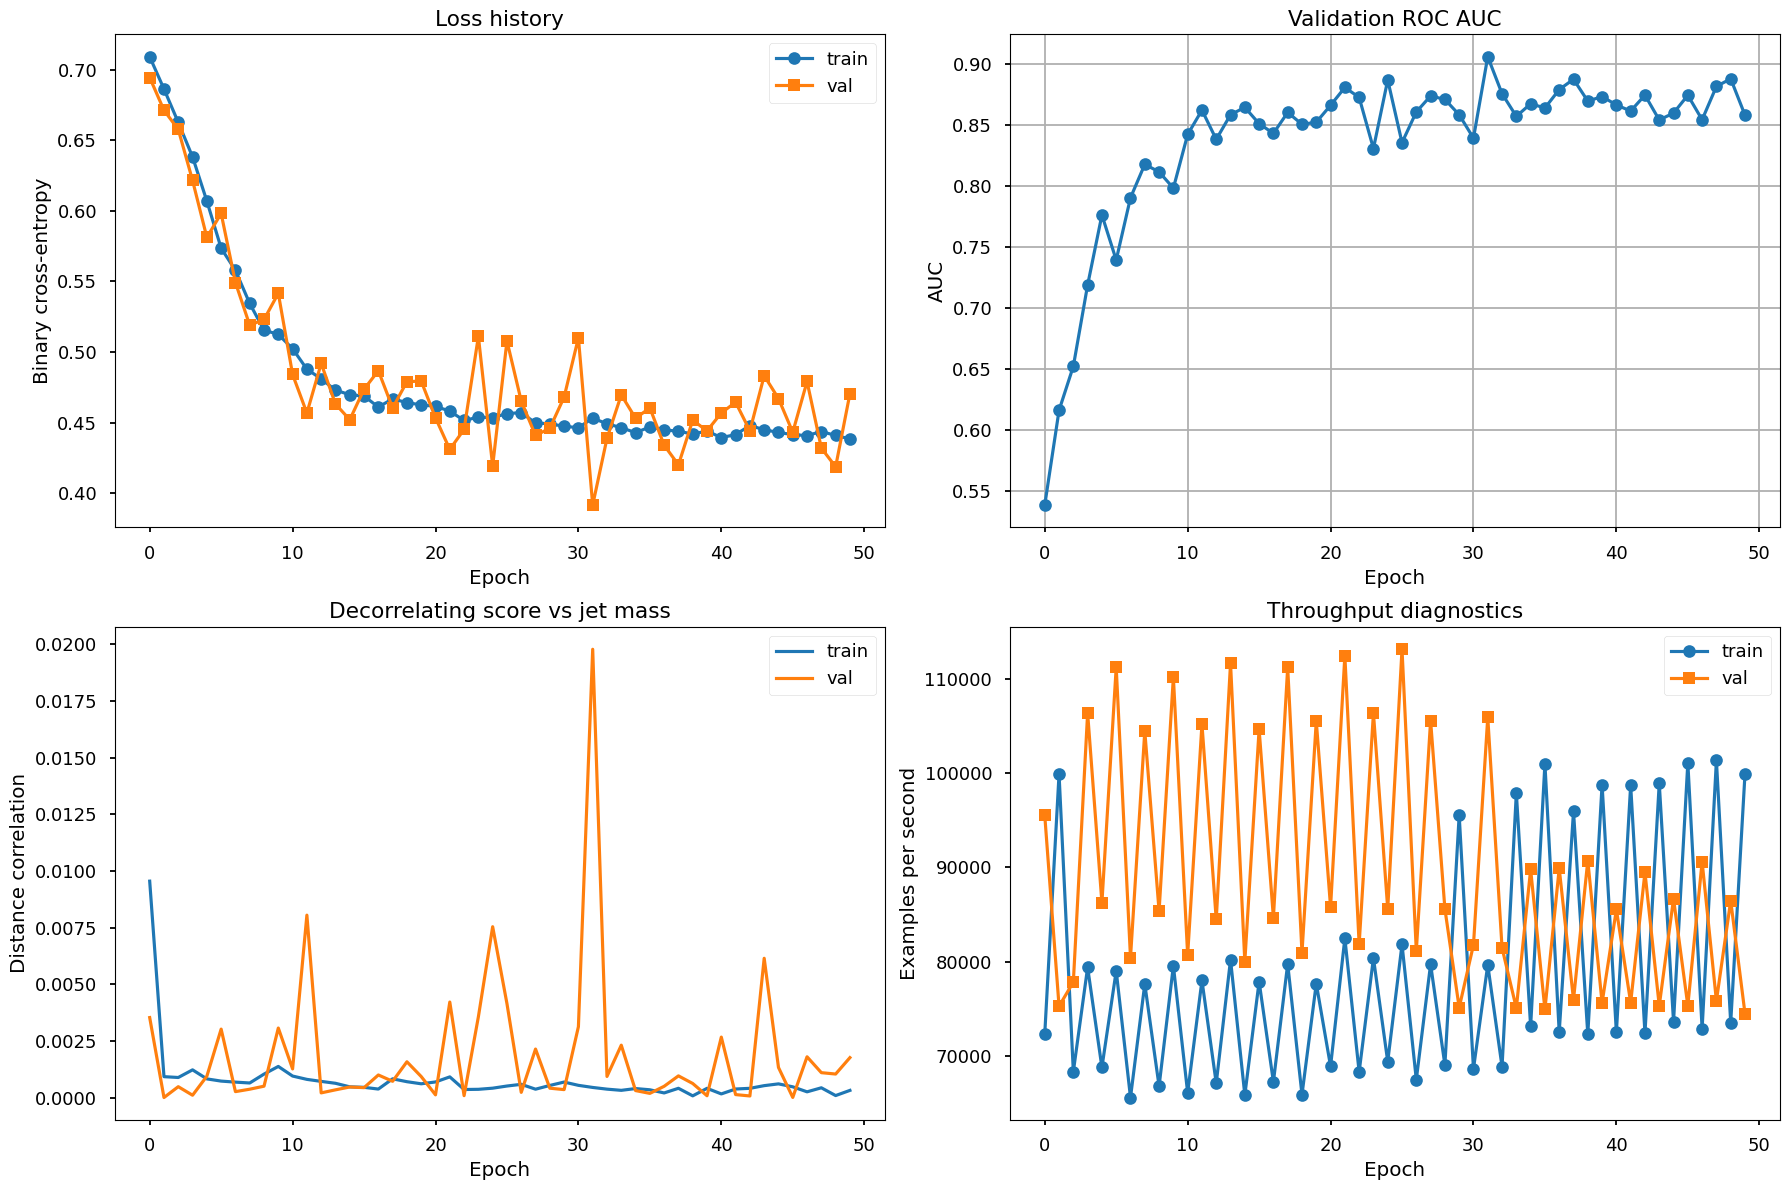

In [15]:

# Visual summary of training history (losses, AUC, decorrelation, throughput).
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

# Panel 0: weighted binary cross-entropy on train vs validation sets.
axes[0].plot(history_df["epoch"], history_df["train_loss_cls"], label="train", marker="o")
axes[0].plot(history_df["epoch"], history_df["val_loss_cls"], label="val", marker="s")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Binary cross-entropy")
axes[0].set_title("Loss history")
axes[0].legend()

# Panel 1: AUC progression across epochs (higher is better signal/background separation).
axes[1].plot(history_df["epoch"], history_df["val_auc"], marker="o")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUC")
axes[1].set_title("Validation ROC AUC")
axes[1].grid(True)

# Panel 2: distance correlation term monitoring the DisCo penalty strength.
if "train_dCorr_s_m" in history_df.columns:
    axes[2].plot(history_df["epoch"], history_df["train_dCorr_s_m"], label="train")
if "val_dCorr_s_m" in history_df.columns:
    axes[2].plot(history_df["epoch"], history_df["val_dCorr_s_m"], label="val")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Distance correlation")
axes[2].set_title("Decorrelating score vs jet mass")
axes[2].legend()

# Panel 3: runtime throughput useful for planning segmented jobs under time limits.
axes[3].plot(history_df["epoch"], history_df["train_examples_per_second"], label="train", marker="o")
axes[3].plot(history_df["epoch"], history_df["val_examples_per_second"], label="val", marker="s")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("Examples per second")
axes[3].set_title("Throughput diagnostics")
axes[3].legend()

plt.tight_layout()
plt.show()



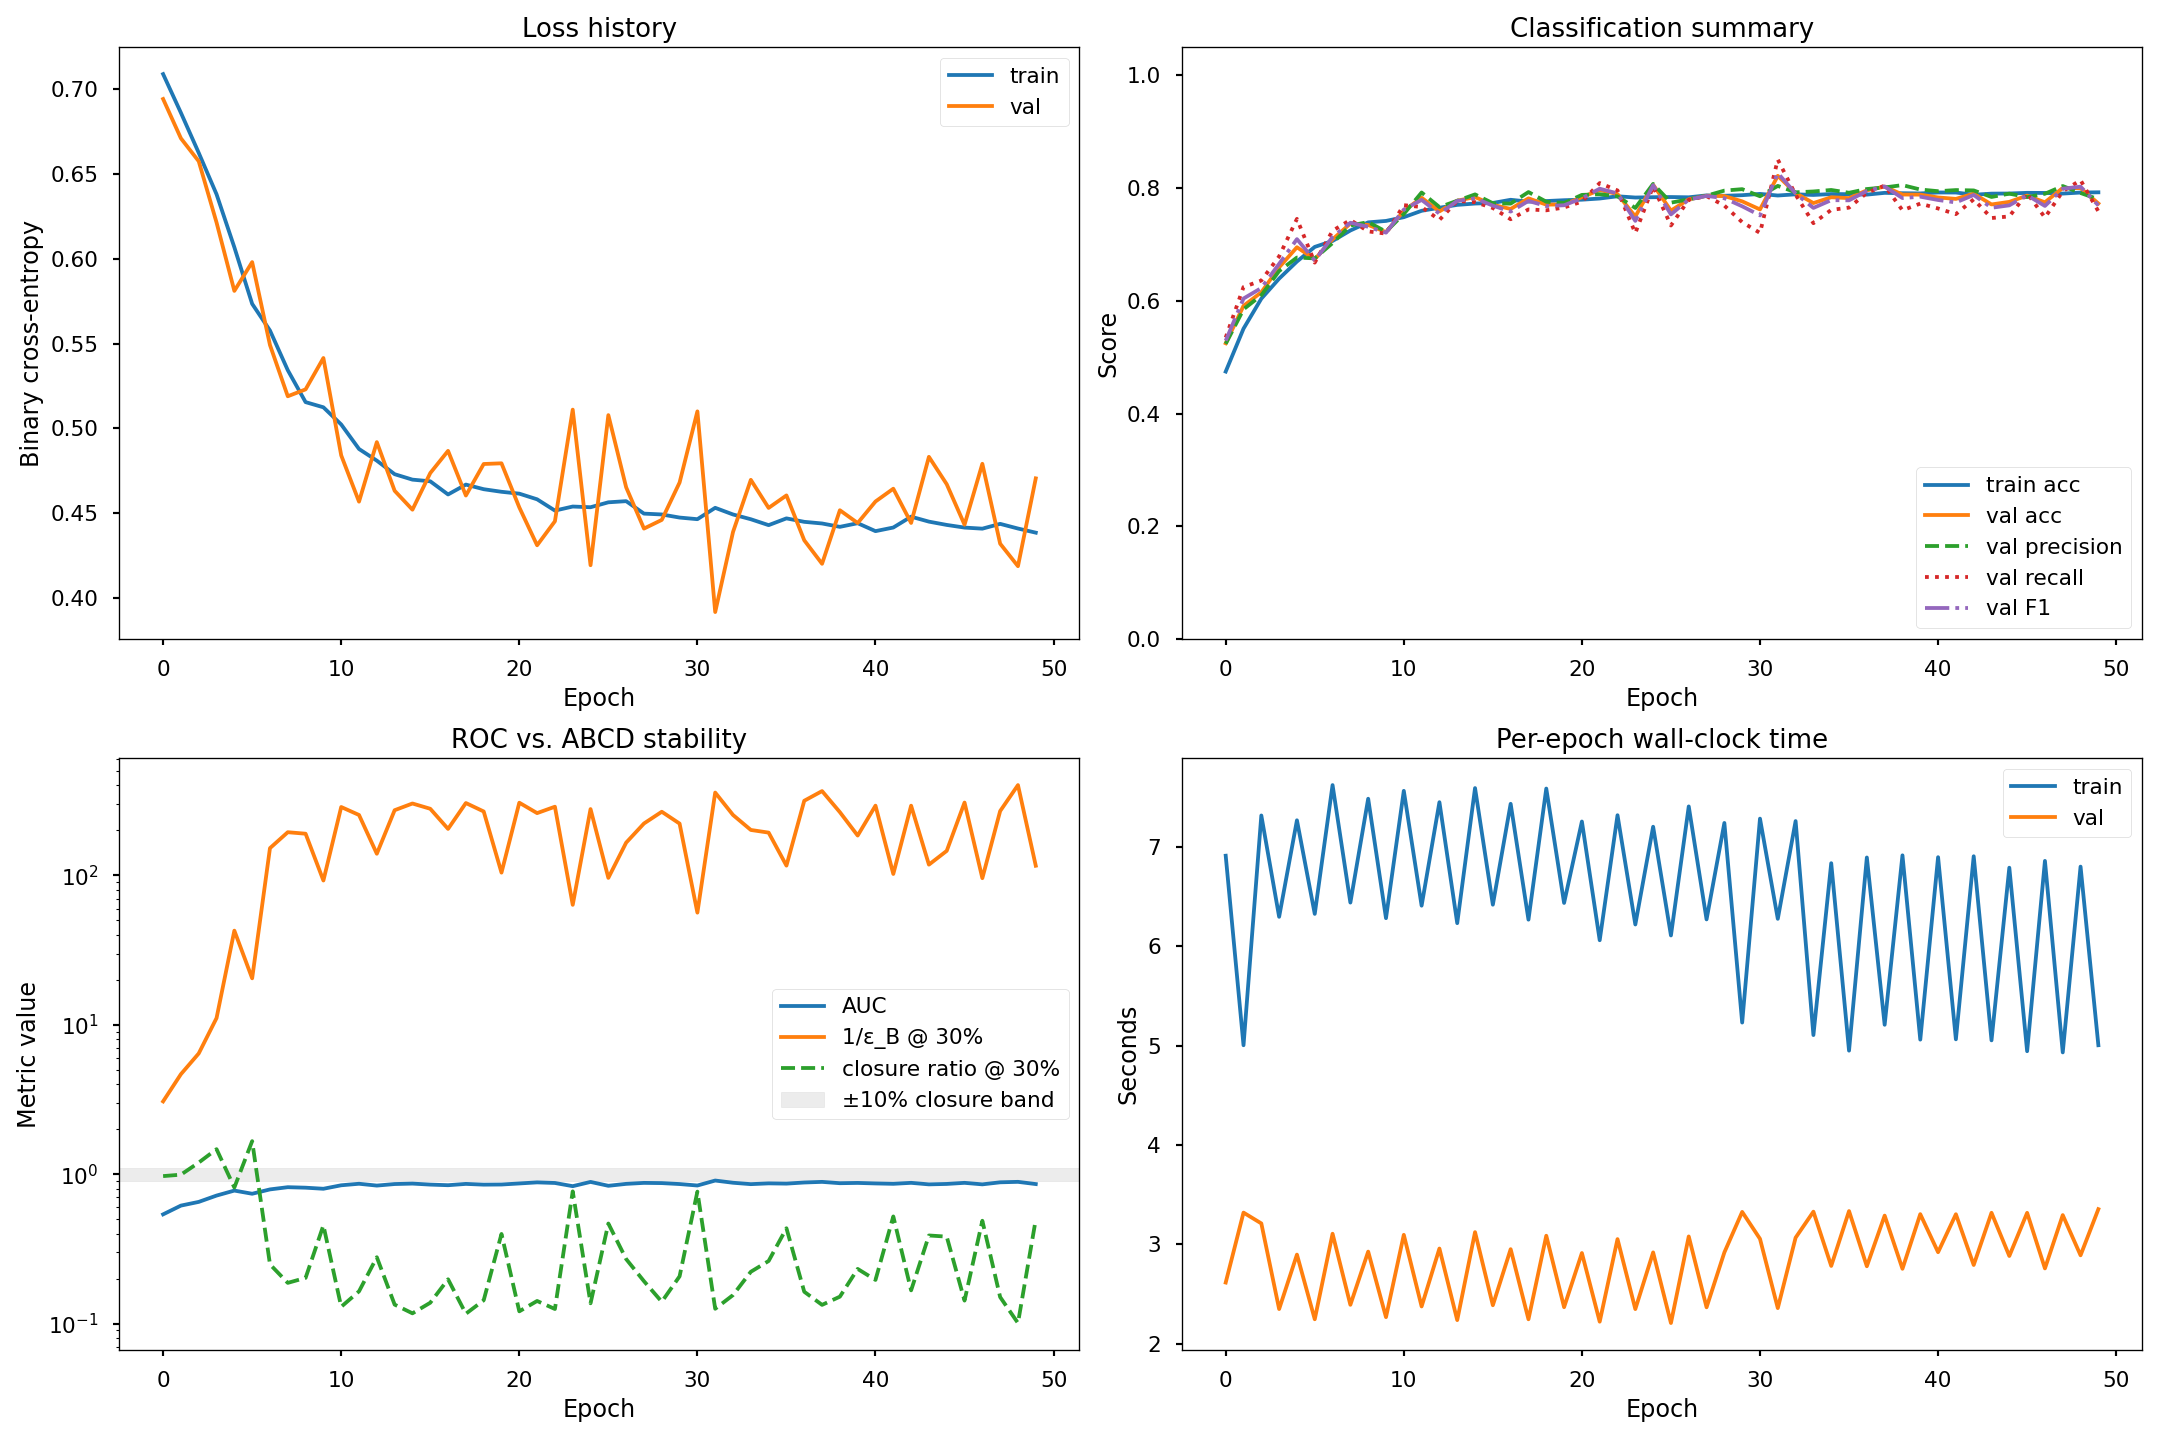

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

# # Loss evolution
# axes[0].plot(history_df["epoch"], history_df["train_loss_cls"], label="train", marker="o")
# axes[0].plot(history_df["epoch"], history_df["val_loss_cls"], label="val", marker="s")
# axes[0].set_xlabel("Epoch")
# axes[0].set_ylabel("Binary cross-entropy")
# axes[0].set_title("Loss history")
# axes[0].legend()

# # Classification metrics
# axes[1].plot(history_df["epoch"], history_df["train_accuracy"], label="train acc", marker="o")
# axes[1].plot(history_df["epoch"], history_df["val_accuracy"], label="val acc", marker="s")
# axes[1].plot(history_df["epoch"], history_df["val_precision"], label="val precision", linestyle="--")
# axes[1].plot(history_df["epoch"], history_df["val_recall"], label="val recall", linestyle=":")
# axes[1].plot(history_df["epoch"], history_df["val_f1"], label="val F1", linestyle="-." )
# axes[1].set_xlabel("Epoch")
# axes[1].set_ylabel("Score")
# axes[1].set_ylim(0.0, 1.05)
# axes[1].set_title("Classification summary")
# axes[1].legend(loc="lower right")

# # ABCD closure and ROC
# axes[2].plot(history_df["epoch"], history_df["val_auc"], label="AUC", marker="o")
# axes[2].plot(history_df["epoch"], 1.0 / np.maximum(history_df["background_eff_at_30pct_sig"], 1e-6), label="1/ε_B @ 30%", marker="s")
# axes[2].plot(history_df["epoch"], history_df["abcd_closure_ratio_30pct"], label="closure ratio @ 30%", linestyle="--")
# axes[2].axhspan(0.9, 1.1, color="grey", alpha=0.15, label="±10% closure band")
# axes[2].set_xlabel("Epoch")
# axes[2].set_ylabel("Metric value")
# axes[2].set_title("ROC vs. ABCD stability")
# axes[2].legend()
# axes[2].set_yscale("log")

# # Runtime diagnostics
# axes[3].plot(history_df["epoch"], history_df["train_epoch_seconds"], label="train", marker="o")
# axes[3].plot(history_df["epoch"], history_df["val_epoch_seconds"], label="val", marker="s")
# axes[3].set_xlabel("Epoch")
# axes[3].set_ylabel("Seconds")
# axes[3].set_title("Per-epoch wall-clock time")
# axes[3].legend()

# plt.tight_layout()
# plt.show()

# Safer plotting for HPC: chunk long paths, decimate, sanitize, and limit rows
plt.rcParams['agg.path.chunksize'] = 10000
plot_df = history_df.tail(min(len(history_df), 2000)).copy()

def decimate(n):  # reduce marker density
    return max(1, n // 200)

# Panel 0: loss
axes[0].plot(plot_df["epoch"], plot_df["train_loss_cls"], label="train", marker=None)
axes[0].plot(plot_df["epoch"], plot_df["val_loss_cls"], label="val", marker=None)
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Binary cross-entropy"); axes[0].set_title("Loss history"); axes[0].legend()

# Panel 1: classification summary (no markers for long series)
axes[1].plot(plot_df["epoch"], plot_df["train_accuracy"], label="train acc")
axes[1].plot(plot_df["epoch"], plot_df["val_accuracy"], label="val acc")
axes[1].plot(plot_df["epoch"], plot_df["val_precision"], label="val precision", linestyle="--")
axes[1].plot(plot_df["epoch"], plot_df["val_recall"], label="val recall", linestyle=":")
axes[1].plot(plot_df["epoch"], plot_df["val_f1"], label="val F1", linestyle="-.")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Score"); axes[1].set_ylim(0.0, 1.05); axes[1].set_title("Classification summary")
axes[1].legend(loc="lower right")

# Panel 2: ROC vs ABCD stability (log-safe)
bkg_eff = plot_df.get("background_eff_at_30pct_sig")
if bkg_eff is not None:
    inv_bkg = 1.0 / np.clip(bkg_eff.astype(float), 1e-6, 1e6)
    axes[2].plot(plot_df["epoch"], plot_df["val_auc"], label="AUC")
    axes[2].plot(plot_df["epoch"], inv_bkg, label="1/ε_B @ 30%")
    if np.all(inv_bkg > 0):
        axes[2].set_yscale("log")
    axes[2].plot(plot_df["epoch"], plot_df.get("abcd_closure_ratio_30pct", np.nan), label="closure ratio @ 30%", linestyle="--")
    axes[2].axhspan(0.9, 1.1, color="grey", alpha=0.15, label="±10% closure band")
    axes[2].set_xlabel("Epoch"); axes[2].set_ylabel("Metric value"); axes[2].set_title("ROC vs. ABCD stability"); axes[2].legend()
else:
    axes[2].set_visible(False)

# Panel 3: runtime diagnostics
axes[3].plot(plot_df["epoch"], plot_df["train_epoch_seconds"], label="train")
axes[3].plot(plot_df["epoch"], plot_df["val_epoch_seconds"], label="val")
axes[3].set_xlabel("Epoch"); axes[3].set_ylabel("Seconds"); axes[3].set_title("Per-epoch wall-clock time"); axes[3].legend()

plt.tight_layout()
plt.savefig("metrics_compact.png", dpi=120)  # avoid massive inline payload
plt.close(fig)
from IPython.display import Image, display
display(Image("metrics_compact.png"))


## 6. Evaluation (`evaluation.py` lines 1-70)

We reproduce the single-score diagnostics: ROC curves, background mass sculpting, and the Jensen-Shannon divergence versus background rejection figure of merit used in the paper.


JSDvsR 10 0.100008
JSDvsR 30 0.299984
JSDvsR 60 0.600008
Test-set diagnostics:
  AUC = 0.858
  Accuracy = 0.772
  Precision = 0.781
  Recall = 0.757
  F1-score = 0.769
  Background distance-correlation(score, mass) = 0.0027


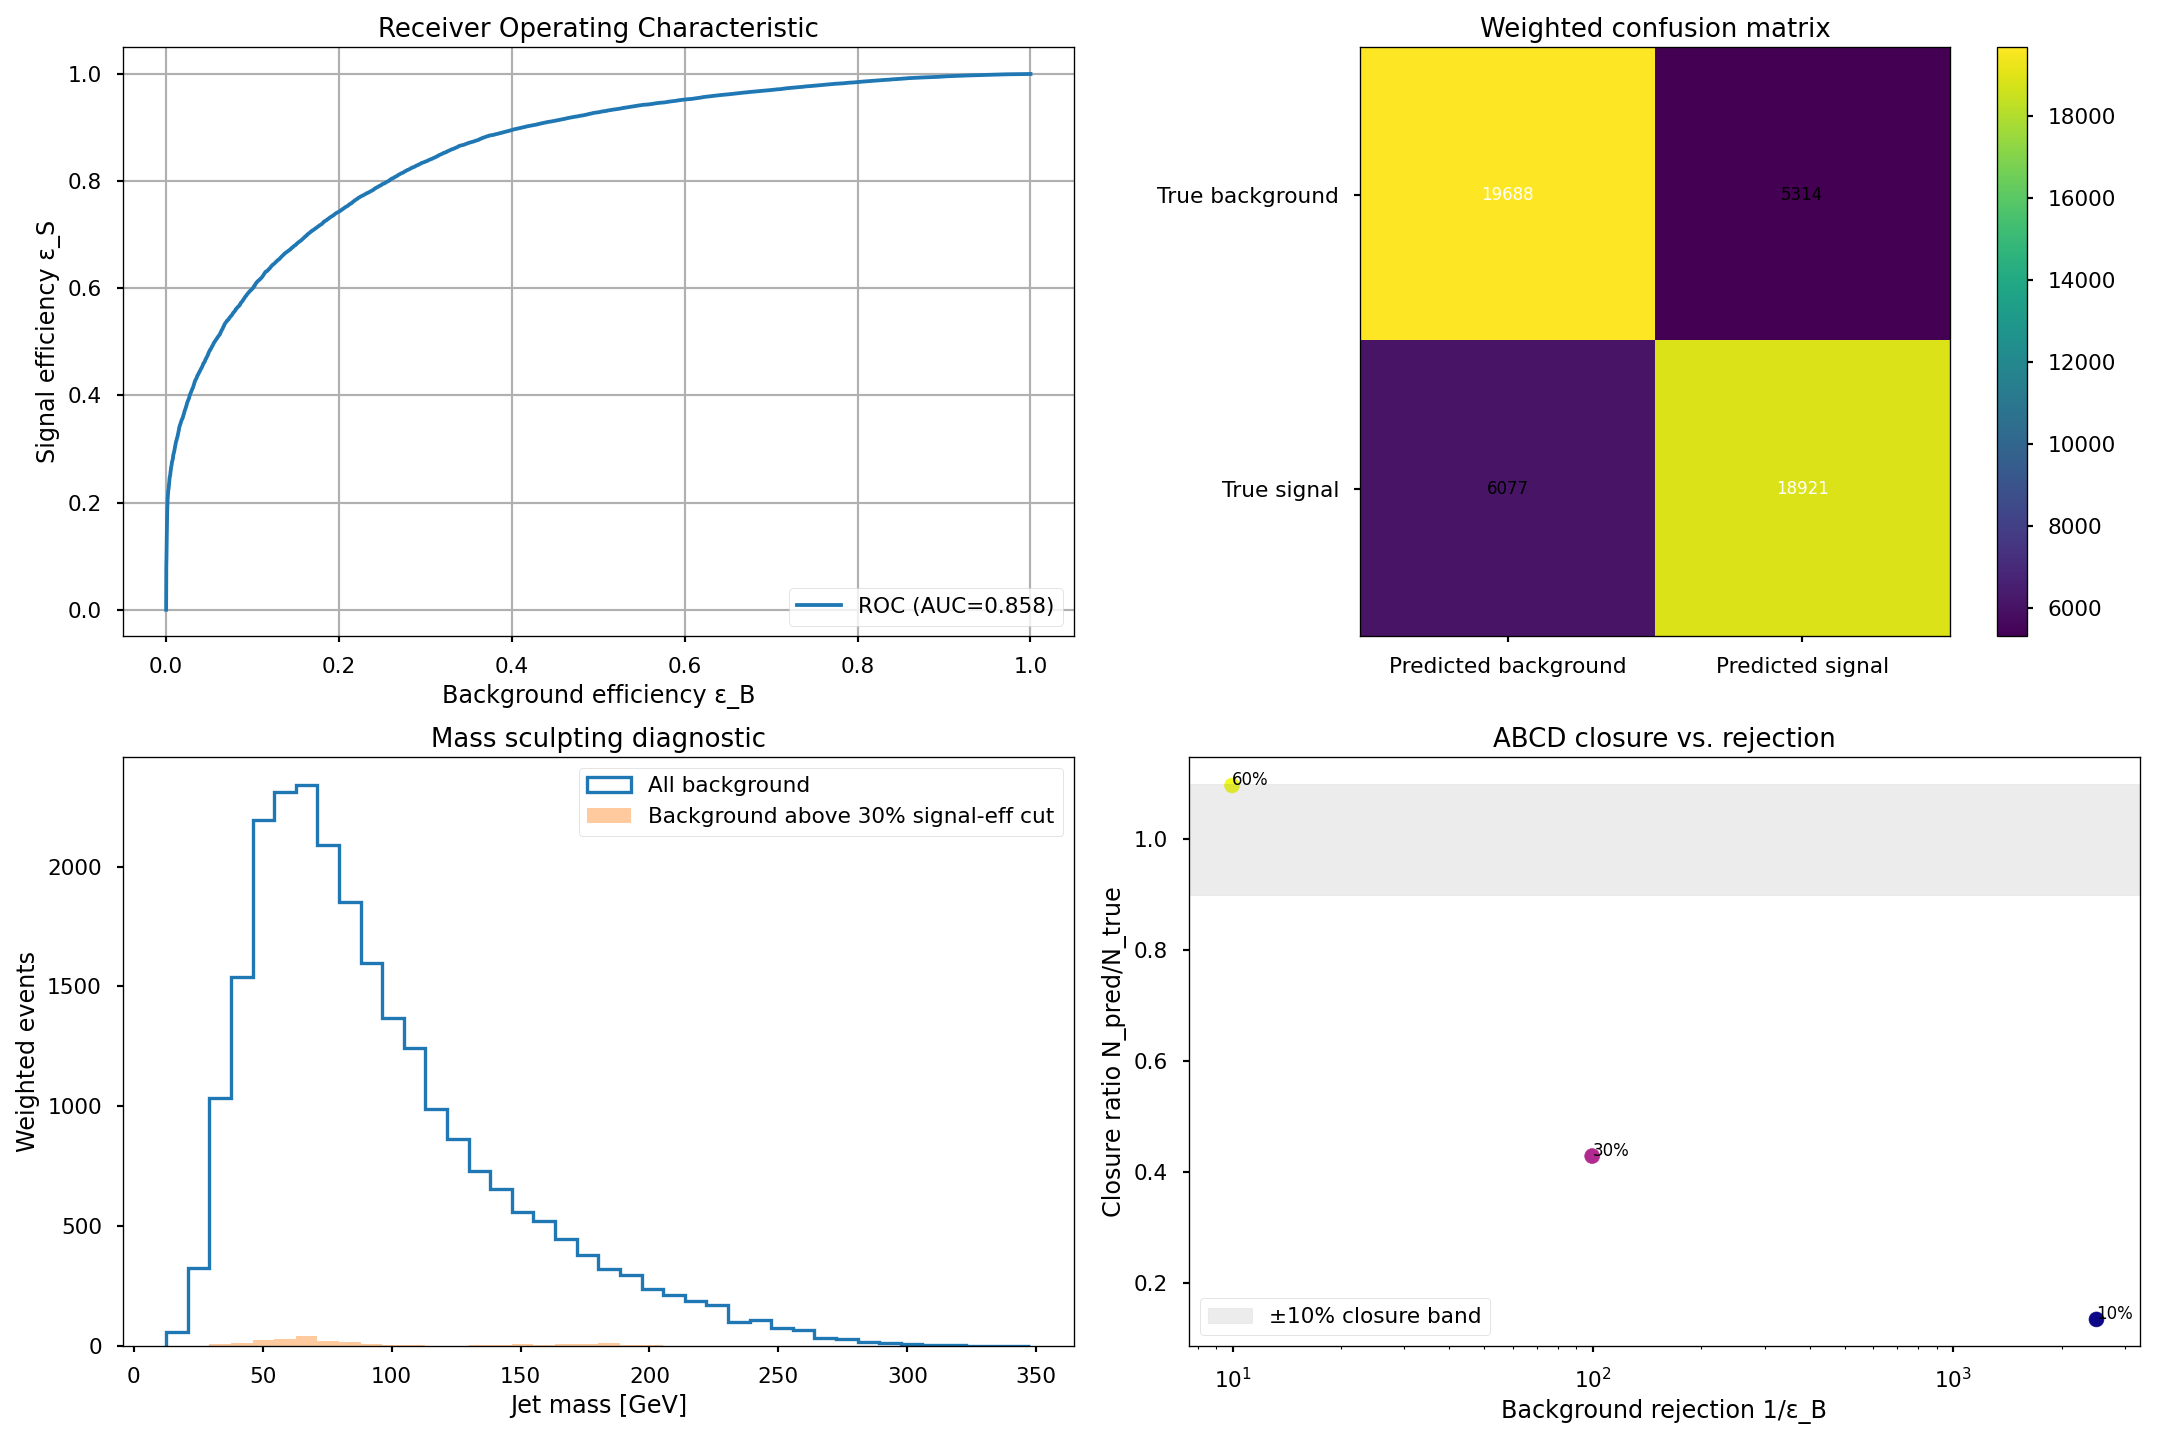

,0
closure_ratio_mean,0.553035
closure_ratio_std,0.402900
closure_ratio_min,0.133813
closure_ratio_max,1.096835
closure_ratio_median,0.428456
pull_mean,0.949205
pull_std,1.312543
pull_min,-0.777347
pull_max,2.402749
pull_median,1.222213


In [17]:
from evaluation import JSDvsR  # re-import to ensure the latest definition is in scope

s_test, y_test, w_test, m_test, test_metrics = evaluate(model, test_loader)

classification_test = compute_epoch_classification_metrics(s_test, y_test, w_test)
roc_test = compute_roc_diagnostics(s_test, y_test, w_test)
abcd_test = compute_abcd_statistics(s_test, m_test, y_test, w_test)
jsd_test = compute_jsd_summary(s_test, m_test, y_test, w_test)

background = y_test < 0.5
if background.any():
    d_test = distance_corr_safe(
        torch.as_tensor(s_test[background]),
        torch.as_tensor(m_test[background]),
        torch.ones_like(torch.as_tensor(m_test[background])),
    ).item()
else:
    d_test = float("nan")

print("Test-set diagnostics:")
print(f"  AUC = {roc_test['auc']:.3f}")
print(f"  Accuracy = {classification_test['accuracy']:.3f}")
print(f"  Precision = {classification_test['precision']:.3f}")
print(f"  Recall = {classification_test['recall']:.3f}")
print(f"  F1-score = {classification_test['f1']:.3f}")
print(f"  Background distance-correlation(score, mass) = {d_test:.4f}")

plt.rcParams['agg.path.chunksize'] = 10000

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

def decimate(n): return max(1, n // 1000)

# ROC curve (decimate)
fpr = np.asarray(roc_test["fpr"], dtype=float)
tpr = np.asarray(roc_test["tpr"], dtype=float)
step = decimate(len(fpr))
axes[0].plot(fpr[::step], tpr[::step], label=f"ROC (AUC={roc_test['auc']:.3f})")
axes[0].set_xlabel("Background efficiency ε_B")
axes[0].set_ylabel("Signal efficiency ε_S")
axes[0].set_title("Receiver Operating Characteristic")
axes[0].legend(loc="lower right"); axes[0].grid(True)

# Confusion matrix (unchanged, small)
cm = classification_test["confusion_matrix"]
im = axes[1].imshow(cm, cmap="viridis")
axes[1].set_xticks([0, 1]); axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(["Predicted background", "Predicted signal"])
axes[1].set_yticklabels(["True background", "True signal"])
axes[1].set_title("Weighted confusion matrix")
for (i, j), value in np.ndenumerate(cm):
    axes[1].text(j, i, f"{value:.0f}", ha="center", va="center",
                 color="white" if value > cm.max()/2 else "black")
fig.colorbar(im, ax=axes[1])

# Mass sculpting (unchanged)
nbins = ABCD_HISTOGRAM_BINS
mass_range = (m_test.min(), m_test.max())
axes[2].hist(m_test[background], bins=nbins, range=mass_range, weights=w_test[background],
             histtype="step", label="All background", linewidth=2)
cut = weighted_quantile(s_test[y_test > 0.5], 1 - 0.3, w_test[y_test > 0.5])
sel = background & (s_test > cut)
axes[2].hist(m_test[sel], bins=nbins, range=mass_range, weights=w_test[sel],
             histtype="stepfilled", alpha=0.4, label="Background above 30% signal-eff cut")
axes[2].set_xlabel("Jet mass [GeV]"); axes[2].set_ylabel("Weighted events")
axes[2].set_title("Mass sculpting diagnostic"); axes[2].legend()

# ABCD closure vs rejection (clip + limit annotations)
rejections = np.asarray([item["background_rejection"] for item in jsd_test], dtype=float)
closures = np.asarray([item["closure_ratio"] for item in abcd_test["per_efficiency"]], dtype=float)
labels_eff = [int(item["target_signal_efficiency"] * 100) for item in abcd_test["per_efficiency"]]
rej_clip = np.clip(rejections, 1e-6, 1e6)
axes[3].scatter(rej_clip, closures, c=labels_eff, cmap="plasma", s=80)
# annotate at most 10 evenly spaced points
if len(rej_clip) > 0:
    idx = np.linspace(0, len(rej_clip)-1, num=min(10, len(rej_clip)), dtype=int)
    for i in idx:
        axes[3].annotate(f"{labels_eff[i]}%", (rej_clip[i], closures[i]))
axes[3].axhspan(0.9, 1.1, color="grey", alpha=0.15, label="±10% closure band")
axes[3].set_xlabel("Background rejection 1/ε_B")
axes[3].set_ylabel("Closure ratio N_pred/N_true")
axes[3].set_title("ABCD closure vs. rejection")
if np.all(rej_clip > 0):
    axes[3].set_xscale("log")
axes[3].legend()

plt.tight_layout()
plt.savefig("test_metrics_compact.png", dpi=120)
plt.close(fig)
from IPython.display import Image, display
display(Image("test_metrics_compact.png"))

# Tabulate per-efficiency ABCD and JSD metrics for deeper analysis
abcd_rows = []
for abcd_entry, jsd_entry in zip(abcd_test["per_efficiency"], jsd_test):
    eff = int(abcd_entry["target_signal_efficiency"] * 100)
    abcd_rows.append({
        "signal_efficiency_percent": eff,
        "score_cut": abcd_entry["score_cut"],
        "background_prediction": abcd_entry["predicted_bg"],
        "closure_ratio": abcd_entry["closure_ratio"],
        "closure_error_percent": abcd_entry["closure_error_pct"],
        "pull": abcd_entry["pull"],
        "transfer_factor_B_over_D": abcd_entry["transfer_factor_B_over_D"],
        "transfer_factor_C_over_D": abcd_entry["transfer_factor_C_over_D"],
        "sideband_ratio_B_over_C": abcd_entry["sideband_ratio_B_over_C"],
        "sideband_stability": abcd_entry["sideband_stability"],
        "signal_in_A": abcd_entry["signal_in_A"],
        "observed_total_in_A": abcd_entry["observed_total_in_A"],
        "asimov_significance": abcd_entry["asimov_significance"],
        "background_rejection": jsd_entry["background_rejection"],
        "inverse_jsd": jsd_entry["inverse_jsd"],
    })
abcd_df = pd.DataFrame(abcd_rows)
abcd_df

aggregated_df = pd.json_normalize(abcd_test["aggregated"], sep="_")
aggregated_df.T




## 7. Persist artefacts

Save inference scores and the trained model weights for downstream ABCDisCo or `pyhf` studies.


In [18]:
def to_serializable(obj: Any):
    # Convert numpy scalars/arrays and torch tensors to built-in Python types recursively.
    if isinstance(obj, (np.floating, np.integer, np.bool_)):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if torch.is_tensor(obj):
        if obj.ndim == 0:
            return obj.item()
        return obj.detach().cpu().tolist()
    if isinstance(obj, dict):
        return {str(k): to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [to_serializable(v) for v in obj]
    return obj

results_df = pd.DataFrame({
    "score": s_test,
    "label": y_test,
    "weight": w_test,
    "mass": m_test,
})
results_df.head()

summary_payload = {
    "classification": {k: (v.tolist() if isinstance(v, np.ndarray) else float(v) if np.isscalar(v) else v) for k, v in classification_test.items() if k != "confusion_matrix"},
    "confusion_matrix": classification_test["confusion_matrix"].tolist(),
    "roc": {k: (v.tolist() if isinstance(v, np.ndarray) else float(v)) for k, v in roc_test.items()},
    "abcd": abcd_test,
    "jsd": jsd_test,
    "distance_correlation": d_test,
}
summary_path = CHECKPOINT_DIR / "test_evaluation.json"
with open(summary_path, "w") as handle:
    json.dump(to_serializable(summary_payload), handle, indent=2)
print(f"Saved detailed test summary to {summary_path}")



Saved detailed test summary to /global/u2/s/sungwon/QML_project/ABCDisCo/notebook/checkpoints_single_disco/test_evaluation.json



## 8. Extending to Double-DisCo & QML studies

- **Recovering the paper-level numbers**: set `FULL_DATASET = True`, increase `EPOCHS` to 200, and sweep `LAMBDA_MASS` in the range 50-400 as in the reference scans.
- **Quantum experiments**: switch `BACKEND = "qml"`, tune `N_QUBITS`/`QML_LAYERS`, and initialise the PennyLane device with `qml.seed(SEED)` for reproducibility.
- **Transition to Double-DisCo**: after validating this notebook, open `ABCDisCo_tutorial.ipynb` for the two-network variant and reuse the saved preprocessing steps to initialise the dual heads.
